In [1]:
!pip uninstall pygeos
!pip uninstall rtree
!sudo apt install libspatialindex-dev
!pip install rtree
!pip install pygeos
!pip install geopandas
!pip install mapclassify

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (755 kB/s)
debconf: unable to initialize frontend: Dialog
deb

In [2]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
from functools import reduce
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import mapclassify
import rtree
import pygeos

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/DOT_File/HCI/HCI_Code')

In [5]:
pd.options.display.max_columns = 150
pd.options.display.max_rows = 100

# 1. Data Description

## Social & Economic

**SE_Unemploy:** Unemployment rate
    
~~**SE_Income:** Median household incomes(dollars)~~

~~**SE_Cash:** Percent households receiving cash public assistance~~

~~**SE_Food:** Percent households receiving Food Stamps/Supplemental Nutrition Assistance Program~~

**SE_Insurance:** Percent individuals with health insurance coverage

**SE_Poverty:** Percent individuals ages 18 years and over with incomes below the federal poverty level in the past 12 months

**SE_English:** Percent citizens 18 years old and over speak English less than very well
    
## Education(E)

**E_Advance:** Population 25 years and over who has Bachelor's degree or higher

**E_PreS:** Population 3 to 4 years olds enrolled in school

~~**E_HighS:** Population 15 to 17 year olds enrolled in school~~

## Natural Environment (NE)
**NE_Tem:** Typical summer day surface temperature

**NE_PM25:** PM2.5 levels in air, µg/m3 annual avg.

**NE_Ozone:** Ozone summer seasonal avg. of daily maximum 8-hour concentration in air in parts per billion

## Built Environment (BE)
**BE_TreeD:** Trees density (trees/acre/people)(weighted by population)

**BE_LandMIX:** Land-Use mix of commercial, residential (Employment and household entropy)

**BE_nodeD:** Intersection density in terms of pedestrian-oriented intersections.(number of intersection/acre/people)(weighted by population)

**BE_HFood:** Numbers of supermarkets within 15 min walk distance (0.8 mile) (weighted by population)

**BE_WalkVSDrive:** The area of sidewalks divided by the sum of the area of the roadway segment and the area sidewalks in a given census tract (weighted by population)

**BE_Transit:** Numbers of Transits(train, subway, bus, or ferry stop.) within 15 min walk distance (0.8 mile) (weighted by population)

**BE_Park:** Area(arce) of parks within 15 min walk distance (0.8 mile) (weighted by population)

In [6]:
Health_Status = pd.read_csv('./Data/Processed_Data/Domain/Health_Status.csv', index_col=0)
Health_Status = Health_Status[['MHLTH','PHLTH','GeoID']]
Health_Status.head()

,MHLTH,PHLTH,GeoID
0,19.3,14.0,36005000100
1,13.9,13.4,36005000200
2,12.4,10.8,36005000400
3,16.0,16.8,36005001600
4,16.6,13.9,36005001900


In [7]:
# reversed less than health data to represent healthy level
Health_Status['MH'] = 100-Health_Status['MHLTH']
Health_Status['PH'] = 100-Health_Status['PHLTH']
Health_Status = Health_Status[['MH','PH','GeoID']]
Health_Status.head()

,MH,PH,GeoID
0,80.7,86.0,36005000100
1,86.1,86.6,36005000200
2,87.6,89.2,36005000400
3,84.0,83.2,36005001600
4,83.4,86.1,36005001900


In [8]:
E = pd.read_csv('./Data/Processed_Data/Domain/Education.csv', index_col=0)
NE = pd.read_csv('./Data/Processed_Data/Domain/Environment.csv', index_col=0)
SE = pd.read_csv('./Data/Processed_Data/Domain/Social_Economic.csv', index_col=0)
N = pd.read_csv('./Data/Processed_Data/Domain/Neighborhood.csv', index_col=0)
T = pd.read_csv('./Data/Processed_Data/Domain/Transportation.csv', index_col=0).rename(columns={'BE_nodeD':'T_NodeD'})

In [9]:
# merge data
dfs = [SE, E, NE, N, T, Health_Status]
data  = reduce(lambda left,right: pd.merge(left,right, on='GeoID'), dfs)
data = data.set_index('GeoID')
data.head()

,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH
GeoID,,,,,,,,,,,,,,,,,
36005000200,13.5,93.3,23.0,15.4,29.4,29.9,94.643103,42.521795,8.939136,0.001797,4.504006,0.160274,0.000062,0.002523,1292.521739,86.1,86.6
36005000400,6.2,94.9,7.7,10.8,28.4,53.1,92.135510,42.587127,8.902753,0.009037,4.743882,0.392961,0.000054,0.002078,1353.743590,87.6,89.2
36005001600,4.8,93.6,25.3,17.3,18.5,76.6,96.693606,42.587327,8.949253,0.000000,4.421632,0.442828,0.000058,0.005440,2556.000000,84.0,83.2
36005001900,10.7,85.2,30.4,11.1,24.6,25.3,96.796323,42.051273,9.157725,0.000000,1.428475,0.461624,0.000171,0.021253,836.827957,83.4,86.1
36005002000,18.9,91.0,42.4,13.3,8.4,87.5,93.799532,42.509834,8.983487,0.000000,5.062189,0.274914,0.000049,0.003423,2355.944444,79.5,78.6


## Data Descriptive analysis

In [10]:
data.describe()

,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH
count,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000
mean,6.469767,92.439386,15.780554,18.052994,35.321376,63.102672,94.602181,42.034106,8.844154,0.008999,5.706349,0.440454,0.000117,0.015253,1417.158557,86.113013,87.399307
std,4.241281,4.987025,10.438323,13.716826,20.360162,28.825592,2.189349,0.539997,0.312700,0.038079,2.311218,0.161539,0.000060,0.014852,881.427647,2.851684,3.424482
min,0.000000,58.000000,0.400000,0.000000,2.400000,0.000000,83.718909,41.415744,7.797531,0.000000,0.030578,0.018581,0.000014,0.000245,0.000000,74.900000,74.300000
25%,3.600000,90.100000,8.000000,6.900000,20.500000,43.000000,93.266000,41.540490,8.635673,0.000000,4.247626,0.328408,0.000073,0.007685,868.500000,84.600000,85.600000
50%,5.500000,93.300000,13.000000,15.400000,30.400000,65.200000,94.823719,41.874436,8.894337,0.000000,5.468558,0.432335,0.000103,0.012059,1240.250000,86.600000,87.700000
75%,8.200000,96.000000,21.400000,25.700000,44.800000,87.300000,96.178205,42.484049,9.101770,0.000000,6.857808,0.546249,0.000146,0.018600,1730.333333,88.000000,89.400000
max,39.100000,100.000000,69.800000,80.700000,97.000000,100.000000,100.162658,43.600054,9.297862,0.516161,19.969702,0.960401,0.000435,0.231799,5631.583333,92.200000,95.600000


In [11]:
data.to_csv('./Data/Final_Data/Final_Data.csv')

## Z-Score Data Descriptive analysis

In [12]:
# Z-score transform
scaler=StandardScaler().fit(data)     
X_scale=scaler.transform(data) 
data_Z = pd.DataFrame(X_scale)
data_Z.columns = data.columns
data_Z.head()

,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH
0,1.657983,0.172613,0.691800,-0.193459,-0.290903,-1.152132,0.018696,0.903358,0.303825,-0.189181,-0.520349,-1.734872,-0.904856,-0.857316,-0.141438,-0.004565,-0.233467
1,-0.063621,0.493525,-0.774315,-0.528897,-0.340031,-0.347093,-1.126947,1.024372,0.187446,0.000983,-0.416536,-0.294080,-1.036481,-0.887279,-0.071964,0.521571,0.525959
2,-0.393792,0.232784,0.912197,-0.054909,-0.826395,0.468357,0.955509,1.024743,0.336185,-0.236387,-0.555999,0.014699,-0.970951,-0.660838,1.292362,-0.741154,-1.226564
3,0.997642,-1.452004,1.400902,-0.507021,-0.526716,-1.311752,1.002437,0.031798,1.003038,-0.236387,-1.851376,0.131079,0.898572,0.404112,-0.658561,-0.951608,-0.379511
4,2.931498,-0.288698,2.550796,-0.346594,-1.322585,0.846587,-0.366706,0.881201,0.445692,-0.236387,-0.278779,-1.025024,-1.127284,-0.796684,1.065338,-2.319559,-2.570165


In [13]:
data_Z.describe()

,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH
count,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03
mean,8.437915e-17,-3.269692e-16,-5.625276e-17,9.844234e-17,5.625276e-17,-1.177792e-16,2.081352e-15,-1.036457e-14,1.209434e-15,-2.812638e-17,-3.164218e-16,2.882954e-16,1.476635e-16,-7.031596e-18,-5.625276e-17,-1.350066e-15,9.844234e-17
std,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00
min,-1.525805e+00,-6.907507e+00,-1.473835e+00,-1.316446e+00,-1.617351e+00,-2.189662e+00,-4.972238e+00,-1.145405e+00,-3.347883e+00,-2.363872e-01,-2.456357e+00,-2.612233e+00,-1.703237e+00,-1.010726e+00,-1.608197e+00,-3.933040e+00,-3.826140e+00
25%,-6.767949e-01,-4.692107e-01,-7.455681e-01,-8.132898e-01,-7.281398e-01,-6.975623e-01,-6.104608e-01,-9.143345e-01,-6.668776e-01,-2.363872e-01,-6.313053e-01,-6.937932e-01,-7.285596e-01,-5.096434e-01,-6.226198e-01,-5.306997e-01,-5.255547e-01
50%,-2.287062e-01,1.726132e-01,-2.664453e-01,-1.934595e-01,-2.417758e-01,7.277724e-02,1.012139e-01,-2.957598e-01,1.605249e-01,-2.363872e-01,-1.029108e-01,-5.027740e-02,-2.409072e-01,-2.150568e-01,-2.007565e-01,1.708139e-01,8.782850e-02
75%,4.080514e-01,7.141522e-01,5.384808e-01,5.576289e-01,4.656628e-01,8.396468e-01,7.200377e-01,8.334393e-01,8.240498e-01,-2.363872e-01,4.983276e-01,6.550796e-01,4.777702e-01,2.254658e-01,3.553919e-01,6.618733e-01,5.843768e-01
max,7.695389e+00,1.516432e+00,5.176389e+00,4.568295e+00,3.030128e+00,1.280337e+00,2.540414e+00,2.900638e+00,1.451301e+00,1.332207e+01,6.172885e+00,3.219501e+00,5.258263e+00,1.458403e+01,4.782545e+00,2.135052e+00,2.395318e+00


[2, 0]
[15, 0]
[15, 2]
[15, 4]
[16, 0]
[16, 2]
[16, 4]
[16, 15]


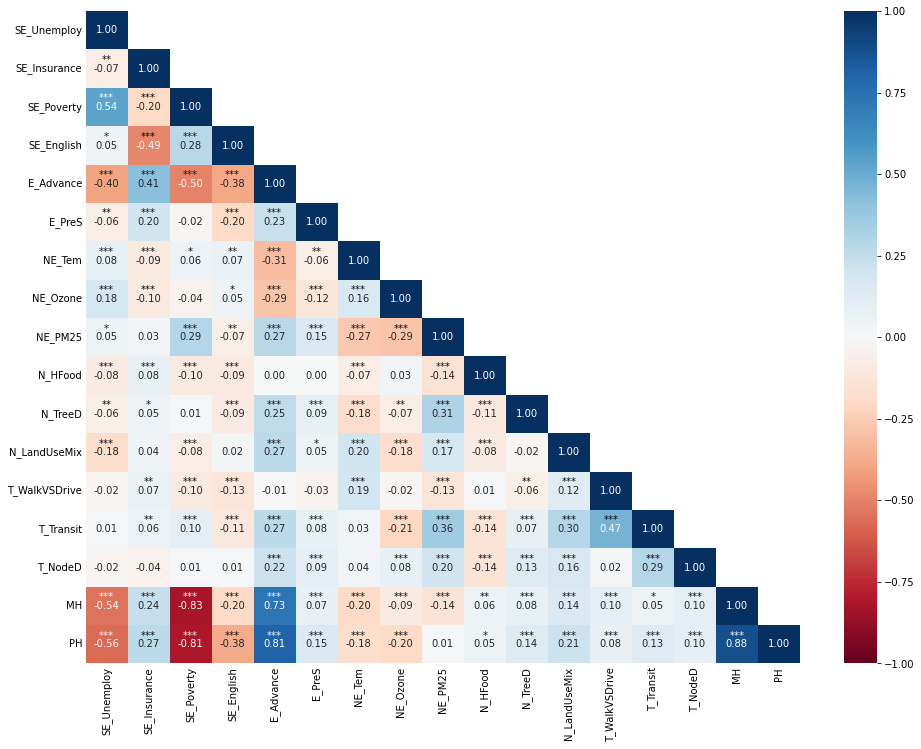

In [ ]:
df_coor=data_Z.corr() 
fig = plt.figure(figsize=(16,12))
ax1 = plt.gca()


mask = np.zeros_like(df_coor)
mask[np.triu_indices_from(mask)] = True
mask2 = mask
mask = (np.flipud(mask)-1)*(-1)
mask = np.rot90(mask,k = -1)

im1 = sns.heatmap(df_coor,annot=True,cmap="RdBu"
, mask=mask # triangle format
,vmax=1,vmin=-1
, fmt='.2f',ax = ax1)

ax1.tick_params(axis = 'both', length=0)

# calculate P-value
df = data_Z
rlist = []
plist = []
for i in df.columns.values:
    for j in df.columns.values:
        r,p = pearsonr(df[i],df[j])
        rlist.append(r)
        plist.append(p)

rarr = np.asarray(rlist).reshape(len(df.columns.values),len(df.columns.values))
parr = np.asarray(plist).reshape(len(df.columns.values),len(df.columns.values))
xlist = ax1.get_xticks()
ylist = ax1.get_yticks()

widthx = 0
widthy = -0.15

for m in ax1.get_xticks():
    for n in ax1.get_yticks():
        pv = (parr[int(m),int(n)])
        rv = (rarr[int(m),int(n)])
        if mask2[int(m),int(n)]<1.:
            if abs(rv) > 0.5:
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'white')
                if  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'white')
                if  pv< 0.001:
                    print([int(m),int(n)])
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'white')
            else: 
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'k')
                elif  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'k')
                elif  pv< 0.001:
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'k')
#plt.savefig(r'Z:\GJ\pearsonr\fig\r_demo.png',dpi=600)
plt.show()

In [ ]:
fig.savefig('./Image/Pearson.jpg', dpi=600,bbox_inches='tight')

## Plot Data

In [14]:
# geo data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson')
ct2010.head()

dataGeo = pd.merge(data, ct2010[['GeoID','boro_name','geometry']], left_index=True, right_on='GeoID').set_index('GeoID')
dataGeo =gpd.GeoDataFrame(dataGeo, geometry=dataGeo.geometry, crs=4326).to_crs(2263)
dataGeo.head()

,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH,boro_name,geometry
GeoID,,,,,,,,,,,,,,,,,,,
36005000200,13.5,93.3,23.0,15.4,29.4,29.9,94.643103,42.521795,8.939136,0.001797,4.504006,0.160274,0.000062,0.002523,1292.521739,86.1,86.6,Bronx,"POLYGON ((1023972.528 232680.658, 1023970.431 ..."
36005000400,6.2,94.9,7.7,10.8,28.4,53.1,92.135510,42.587127,8.902753,0.009037,4.743882,0.392961,0.000054,0.002078,1353.743590,87.6,89.2,Bronx,"POLYGON ((1026849.274 235548.774, 1026749.976 ..."
36005001600,4.8,93.6,25.3,17.3,18.5,76.6,96.693606,42.587327,8.949253,0.000000,4.421632,0.442828,0.000058,0.005440,2556.000000,84.0,83.2,Bronx,"POLYGON ((1024344.112 238946.021, 1024391.333 ..."
36005001900,10.7,85.2,30.4,11.1,24.6,25.3,96.796323,42.051273,9.157725,0.000000,1.428475,0.461624,0.000171,0.021253,836.827957,83.4,86.1,Bronx,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."
36005002000,18.9,91.0,42.4,13.3,8.4,87.5,93.799532,42.509834,8.983487,0.000000,5.062189,0.274914,0.000049,0.003423,2355.944444,79.5,78.6,Bronx,"POLYGON ((1022317.859 237780.872, 1022425.769 ..."


In [18]:
fig, ax = plt.subplots(8,3, figsize=(30,80))

a = dataGeo.columns[:-2]

for i,j in enumerate(a):
    dataGeo.plot(column=j, cmap='Reds_r', ax=ax[i//3][i%3],
                              legend=True, scheme='Quantiles', k=5,legend_kwds={'loc':'upper left','fontsize':'large'},
                              figsize=(5,5))
    label = j
    ax[i//3][i%3].set_title(label, fontsize=20)
    
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig.savefig('./Image/DataPlot.jpg', dpi=600,bbox_inches='tight')

In [19]:
dataGeo.groupby('boro_name').mean()

,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH
boro_name,,,,,,,,,,,,,,,,,
Bronx,9.858750,91.731250,23.667500,20.060625,20.545313,59.135000,94.813702,42.732106,9.067751,3.978859e-03,5.930656,0.393260,0.000109,0.015216,1292.046441,83.551250,84.438437
Brooklyn,6.233887,92.883679,17.176763,17.960996,36.264869,65.982296,94.334651,41.532896,8.852000,7.294201e-03,5.754862,0.443252,0.000126,0.015680,1044.390090,86.112725,87.703043
Manhattan,5.507570,95.026693,15.574104,10.630279,61.139841,77.734661,93.398540,41.867000,9.245926,1.185593e-07,7.352868,0.511956,0.000092,0.028781,2567.518874,87.103586,89.213147
Queens,5.700805,90.736876,10.834300,21.687279,31.644928,55.980193,95.279032,42.339793,8.575794,1.141341e-02,5.093072,0.435425,0.000127,0.011345,1692.562497,87.090016,87.804187
Staten Island,4.631132,95.394340,11.914151,8.904717,33.895283,62.518868,94.673194,41.950394,8.736441,4.294774e-02,4.392349,0.423999,0.000082,0.003306,0.000000,85.779245,87.599057


AttributeError: ignored

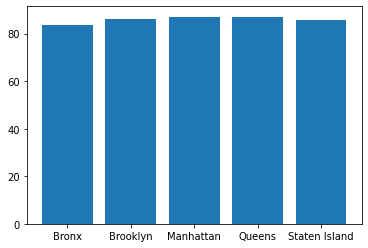

In [20]:
p1 = plt.bar(x=dataGeo.groupby('boro_name').mean().index, height=dataGeo.groupby('boro_name').mean()['MH'])
plt.bar_label(p1,label_type='edge', fmt='%.f')
plt.ylim(0,100)
plt.axhline(y=dataGeo.groupby('boro_name').mean()['MH'].mean(), ls='--', color='r')

AttributeError: ignored

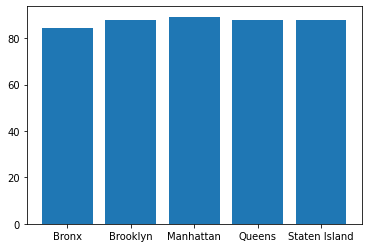

In [21]:
p2 = plt.bar(x=dataGeo.groupby('boro_name').mean().index, height=dataGeo.groupby('boro_name').mean()['PH'])
plt.bar_label(p2,label_type='edge', fmt='%.f')
plt.ylim(0,100)
plt.axhline(y=dataGeo.groupby('boro_name').mean()['PH'].mean(), ls='--', color='r')

# 2. RandomForest Model Analysis

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
data.head()

,BE_TreeD,BE_nodeD,BE_HFood,BE_WalkVSDrive,BE_Transit,BE_Park,BE_LandUseMix,E_Advance,E_PreS,E_HighS,NE_Tem,NE_Ozone,NE_PM25,SE_Unemploy,SE_Income,SE_Cash,SE_Food,SE_Insurance,SE_Poverty,SE_English,MHLTH,PHLTH
36005000200,0.001039,0.000516,0.000000,0.000062,0.001033,0.027208,0.160274,29.4,29.9,100.0,94.643103,42.521795,8.939136,13.5,51100.0,8.3,21.5,93.3,23.0,15.4,13.9,13.4
36005000400,0.000862,0.000332,0.000000,0.000054,0.000610,0.014828,0.392961,28.4,53.1,100.0,92.135510,42.587127,8.902753,6.2,78409.0,7.1,8.4,94.9,7.7,10.8,12.4,10.8
36005001600,0.000784,0.000353,0.000177,0.000058,0.001719,0.025224,0.442828,18.5,76.6,90.6,96.693606,42.587327,8.949253,4.8,34093.0,7.7,35.3,93.6,25.3,17.3,16.0,16.8
36005001900,0.000745,0.000271,0.000578,0.000171,0.010265,0.078188,0.461624,24.6,25.3,93.6,96.796323,42.051273,9.157725,10.7,45156.0,7.7,31.6,85.2,30.4,11.1,16.6,13.9
36005002000,0.000580,0.000412,0.000121,0.000049,0.001279,0.023708,0.274914,8.4,87.5,100.0,93.799532,42.509834,8.983487,18.9,20592.0,11.7,52.6,91.0,42.4,13.3,20.5,21.4


In [ ]:
X_all = data.iloc[:,:-2]
X_BE = data.iloc[:,:7]

In [ ]:
y_MHLTH = data.MHLTH
y_PHLTH = data.PHLTH

## PHLTH: All indicators

310 0.8564975940286313 0.0034222128343180634
310 0.8564975940286313 0.0034222128343180634
310 0.8564975940286313 0.0034222128343180634 0.024015153353889564


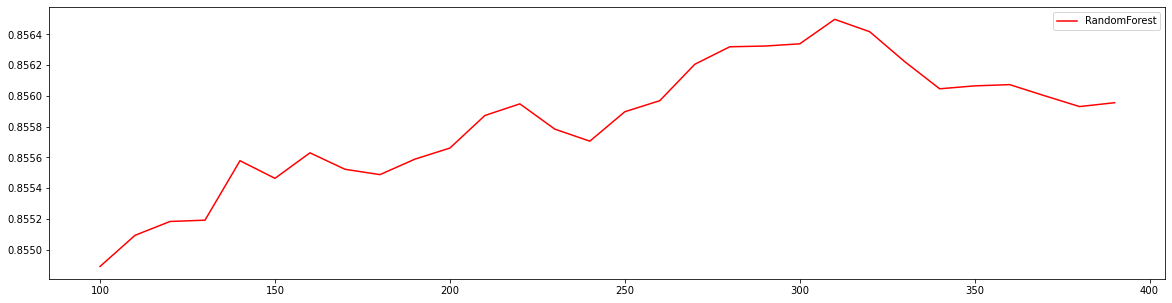

In [ ]:
# Tunning n_estimators
axisx = np.arange(100,400,10)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_PHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

16 0.8566838197276294 0.0033896197207774134
16 0.8566838197276294 0.0033896197207774134
16 0.8566838197276294 0.0033896197207774134 0.023929147248640037


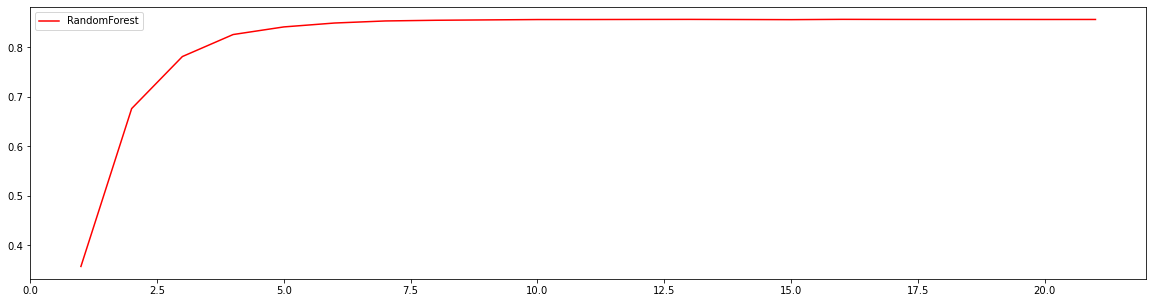

In [ ]:
# Tunning max_depth
axisx = np.arange(1,22,1)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=310
                                ,max_depth=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_PHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

In [ ]:
# best model (our objective is not predict anything, just see the feature importance)
rfs = RandomForestRegressor(n_estimators=310,
                                max_depth=16,
                                n_jobs=-1,
                                random_state=90).fit(X_all,y_PHLTH)

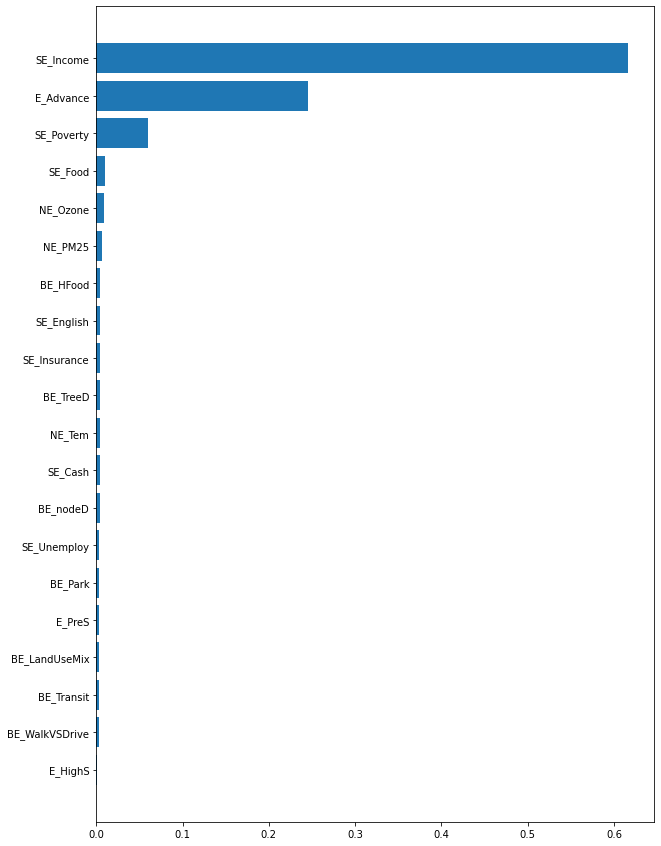

In [ ]:
feature_imp = pd.DataFrame({'name':X_all.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (10,15))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

## MHLTH: All indicators

300 0.7713396151777783 0.009546137459403933
160 0.7692161150425314 0.009405565240129764
300 0.7713396151777783 0.009546137459403933 0.06183170904645047


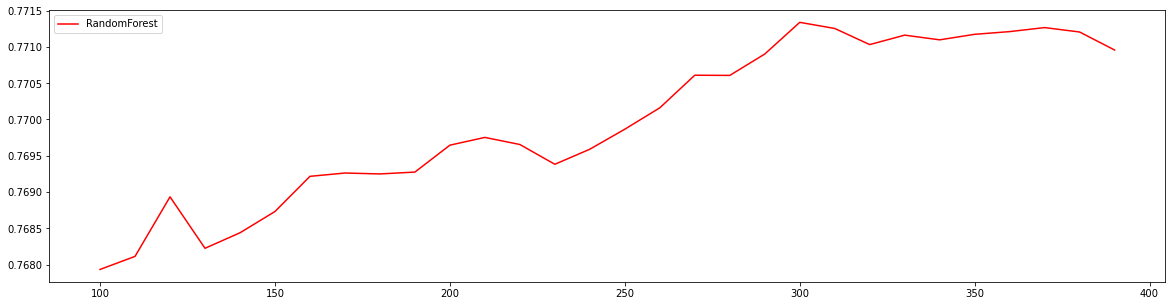

In [ ]:
# Tunning n_estimators
axisx = np.arange(100,400,10)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_MHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

16 0.7721653654695817 0.009375526224679197
16 0.7721653654695817 0.009375526224679197
16 0.7721653654695817 0.009375526224679197 0.06128414691628847


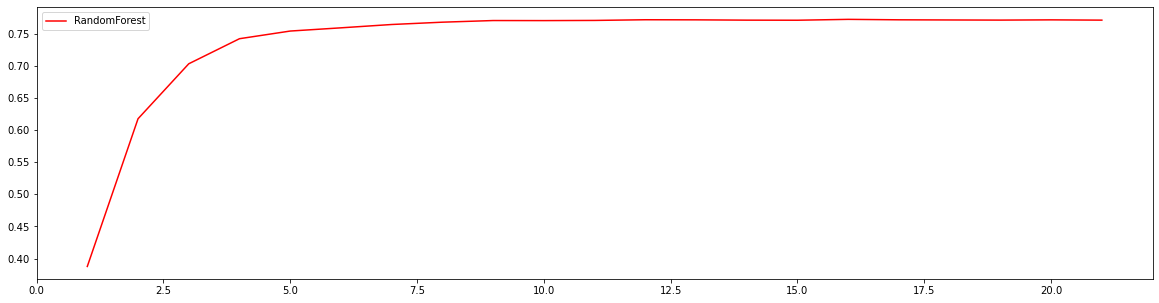

In [ ]:
# Tunning max_depth
axisx = np.arange(1,22,1)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=300
                                ,max_depth=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_MHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

In [ ]:
# our objective is not predict anything, just see the feature importance
rfs = RandomForestRegressor(n_estimators=300
                            ,max_depth=16
                           ,random_state=90).fit(X_all,y_MHLTH)

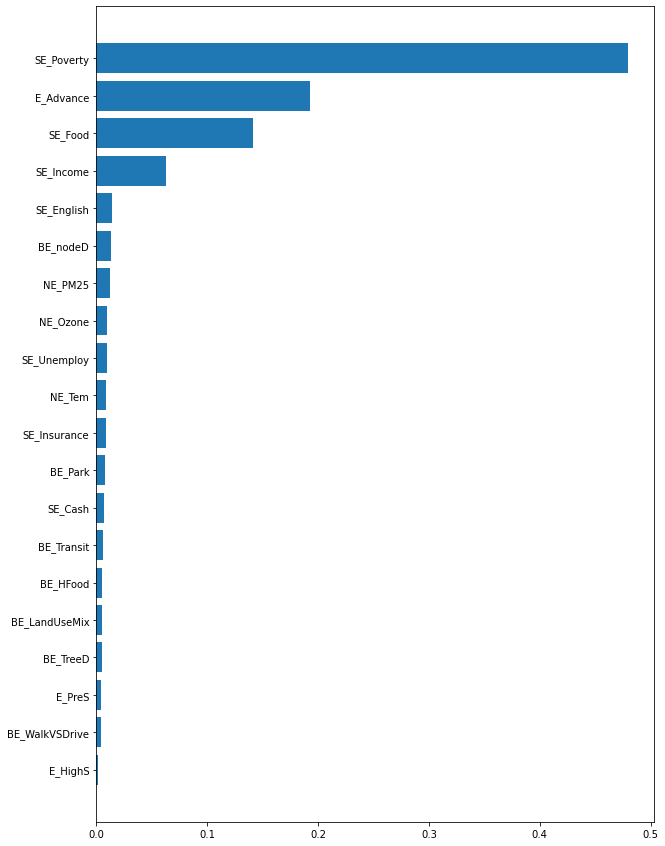

In [ ]:
feature_imp = pd.DataFrame({'name':X_all.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (10,15))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

## PHLTH: Built-Environment

In [ ]:
rfs = RandomForestRegressor().fit(X_BE,y_PHLTH)

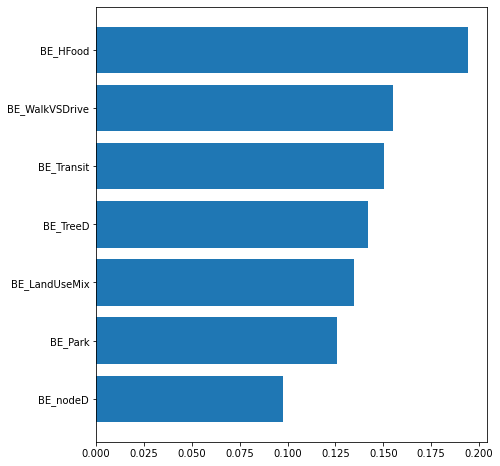

In [ ]:
feature_imp = pd.DataFrame({'name':X_BE.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (7,8))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

## MHLTH: Built-Environment

In [ ]:
rfs = RandomForestRegressor().fit(X_BE,y_MHLTH)

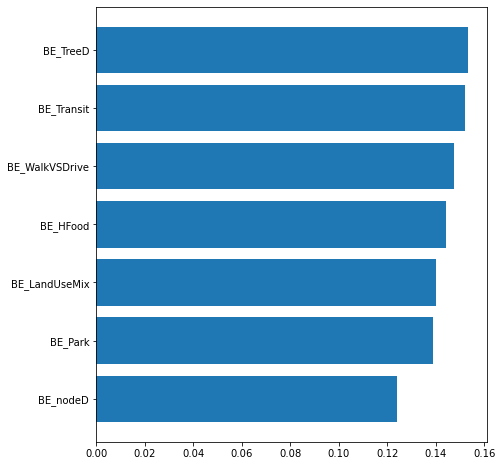

In [ ]:
feature_imp = pd.DataFrame({'name':X_BE.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (7,8))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

# 3. Calculate Score

## Indicators Weight

In [ ]:
# filter out E_HighS, not significant. and SE_Cash SE_Food because they are highly correlate with income and poverty

In [22]:
# reversed features have negative correlation with health 
df_Z = data_Z.copy()
reverse = ['NE_Tem', 'NE_Ozone', 'NE_PM25', 'SE_Unemploy', 'SE_Poverty', 'SE_English']
df_Z[reverse] = df_Z[reverse]*-1
df_Z.head()

,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH
0,-1.657983,0.172613,-0.691800,0.193459,-0.290903,-1.152132,-0.018696,-0.903358,-0.303825,-0.189181,-0.520349,-1.734872,-0.904856,-0.857316,-0.141438,-0.004565,-0.233467
1,0.063621,0.493525,0.774315,0.528897,-0.340031,-0.347093,1.126947,-1.024372,-0.187446,0.000983,-0.416536,-0.294080,-1.036481,-0.887279,-0.071964,0.521571,0.525959
2,0.393792,0.232784,-0.912197,0.054909,-0.826395,0.468357,-0.955509,-1.024743,-0.336185,-0.236387,-0.555999,0.014699,-0.970951,-0.660838,1.292362,-0.741154,-1.226564
3,-0.997642,-1.452004,-1.400902,0.507021,-0.526716,-1.311752,-1.002437,-0.031798,-1.003038,-0.236387,-1.851376,0.131079,0.898572,0.404112,-0.658561,-0.951608,-0.379511
4,-2.931498,-0.288698,-2.550796,0.346594,-1.322585,0.846587,0.366706,-0.881201,-0.445692,-0.236387,-0.278779,-1.025024,-1.127284,-0.796684,1.065338,-2.319559,-2.570165


In [23]:
data_weight = df_Z.corr().iloc[:-2,-2:]
data_weight = data_weight.round(decimals=2)
data_weight

,MH,PH
SE_Unemploy,0.54,0.56
SE_Insurance,0.24,0.27
SE_Poverty,0.83,0.81
SE_English,0.20,0.38
E_Advance,0.73,0.81
E_PreS,0.07,0.15
NE_Tem,0.20,0.18
NE_Ozone,0.09,0.20
NE_PM25,0.14,-0.01
N_HFood,0.06,0.05


In [24]:
data_weight['Average_Coef'] = ((data_weight['MH'] + data_weight['PH'])/2)
data_weight

,MH,PH,Average_Coef
SE_Unemploy,0.54,0.56,0.550
SE_Insurance,0.24,0.27,0.255
SE_Poverty,0.83,0.81,0.820
SE_English,0.20,0.38,0.290
E_Advance,0.73,0.81,0.770
E_PreS,0.07,0.15,0.110
NE_Tem,0.20,0.18,0.190
NE_Ozone,0.09,0.20,0.145
NE_PM25,0.14,-0.01,0.065
N_HFood,0.06,0.05,0.055


In [25]:
data_weight.iloc[0:4,2]

SE_Unemploy     0.550
SE_Insurance    0.255
SE_Poverty      0.820
SE_English      0.290
Name: Average_Coef, dtype: float64

In [26]:
data_weight.iloc[4:6,2]

E_Advance    0.77
E_PreS       0.11
Name: Average_Coef, dtype: float64

In [27]:
data_weight.iloc[6:9,2]

NE_Tem      0.190
NE_Ozone    0.145
NE_PM25     0.065
Name: Average_Coef, dtype: float64

In [28]:
data_weight.iloc[9:12,2]

N_HFood         0.055
N_TreeD         0.110
N_LandUseMix    0.175
Name: Average_Coef, dtype: float64

In [29]:
data_weight.iloc[12:,2]

T_WalkVSDrive    0.09
T_Transit        0.09
T_NodeD          0.10
Name: Average_Coef, dtype: float64

## Domain Score

In [30]:
# domain weight
data_weight['Final_Weight'] = 0
data_weight['Final_Weight'][0:4] = data_weight.iloc[0:4,2]/data_weight.iloc[0:4,2].sum()
data_weight['Final_Weight'][4:6] = data_weight.iloc[4:6,2]/data_weight.iloc[4:6,2].sum()
data_weight['Final_Weight'][6:9] = data_weight.iloc[6:9,2]/data_weight.iloc[6:9,2].sum()
data_weight['Final_Weight'][9:12] = abs(data_weight.iloc[9:12,2])/abs(data_weight.iloc[9:12,2]).sum()
data_weight['Final_Weight'][12:] = abs(data_weight.iloc[12:,2])/abs(data_weight.iloc[12:,2]).sum()
data_weight['Final_Weight'] = data_weight.Final_Weight.round(decimals=3)
data_weight

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,MH,PH,Average_Coef,Final_Weight
SE_Unemploy,0.54,0.56,0.550,0.287
SE_Insurance,0.24,0.27,0.255,0.133
SE_Poverty,0.83,0.81,0.820,0.428
SE_English,0.20,0.38,0.290,0.151
E_Advance,0.73,0.81,0.770,0.875
E_PreS,0.07,0.15,0.110,0.125
NE_Tem,0.20,0.18,0.190,0.475
NE_Ozone,0.09,0.20,0.145,0.363
NE_PM25,0.14,-0.01,0.065,0.162
N_HFood,0.06,0.05,0.055,0.162


In [31]:
data_weight['Final_Weight'][0:4].sum()

0.999

In [32]:
data_weight['Final_Weight'][4:6].sum()

1.0

In [33]:
data_weight['Final_Weight'][6:9].sum()

1.0

In [34]:
data_weight['Final_Weight'][9:12].sum()

1.001

In [35]:
data_weight['Final_Weight'][12:].sum()

0.999

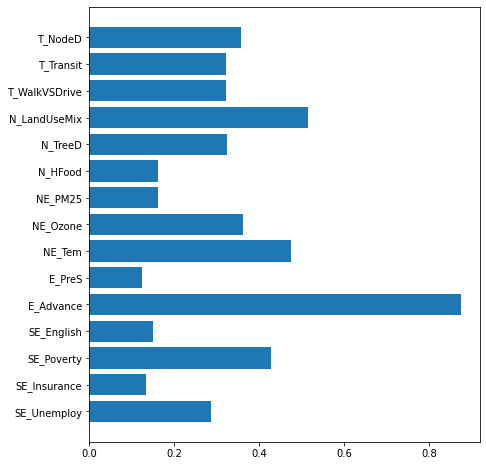

In [36]:
plot, ax = plt.subplots(1,1,figsize = (7,8))
plt.barh(data_weight.index, data_weight.Final_Weight)
plt.show()

In [37]:
df_Score = pd.DataFrame()
for i in df_Z.columns[:-2]:
    df_Score[i] = df_Z[i]*data_weight.loc[i,'Final_Weight']
df_Score

,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD
0,-0.475841,0.022958,-0.296090,0.029212,-0.254541,-0.144017,-0.008881,-0.327919,-0.049220,-0.030647,-0.168593,-0.893459,-0.290459,-0.275198,-0.050493
1,0.018259,0.065639,0.331407,0.079863,-0.297527,-0.043387,0.535300,-0.371847,-0.030366,0.000159,-0.134958,-0.151451,-0.332710,-0.284817,-0.025691
2,0.113018,0.030960,-0.390420,0.008291,-0.723096,0.058545,-0.453867,-0.371982,-0.054462,-0.038295,-0.180144,0.007570,-0.311675,-0.212129,0.461373
3,-0.286323,-0.193116,-0.599586,0.076560,-0.460877,-0.163969,-0.476158,-0.011543,-0.162492,-0.038295,-0.599846,0.067506,0.288442,0.129720,-0.235106
4,-0.841340,-0.038397,-1.091741,0.052336,-1.157262,0.105823,0.174185,-0.319876,-0.072202,-0.038295,-0.090324,-0.527888,-0.361858,-0.255735,0.380326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,0.146861,0.054969,0.433939,0.062246,-0.245943,0.160042,-0.786794,0.048999,-0.003984,-0.029354,-0.338846,0.320097,-0.359130,-0.279357,-0.574126
2017,0.065639,0.065639,0.032013,0.109593,-0.224450,0.089341,-0.434213,0.053353,-0.015240,0.025633,-0.314661,-0.178864,-0.396573,-0.285433,-0.574126
2018,0.038565,0.100317,-0.780043,0.101886,-0.800472,-0.273708,-0.364937,0.058052,-0.029579,0.724907,-0.184402,-0.280566,0.003625,-0.241017,-0.574126
2019,0.295768,0.065639,-0.505256,0.123908,-0.349111,-0.133173,-0.374363,0.065614,-0.041064,1.664413,-0.392915,-0.359099,-0.289519,-0.292794,-0.574126


In [38]:
df_Domain_Score = pd.DataFrame()
df_Domain_Score['SE'] = df_Score.iloc[:,0:4].sum(axis=1)
df_Domain_Score['E'] = df_Score.iloc[:,4:6].sum(axis=1)
df_Domain_Score['NE'] = df_Score.iloc[:,6:9].sum(axis=1)
df_Domain_Score['N'] = df_Score.iloc[:,9:12].sum(axis=1)
df_Domain_Score['T'] = df_Score.iloc[:,12:].sum(axis=1)
df_Domain_Score

,SE,E,NE,N,T
0,-0.719762,-0.398557,-0.386019,-1.092699,-0.616151
1,0.495169,-0.340914,0.133087,-0.286250,-0.643218
2,-0.238150,-0.664551,-0.880310,-0.210868,-0.062431
3,-1.002465,-0.624846,-0.650192,-0.570635,0.183055
4,-1.919142,-1.051438,-0.217893,-0.656507,-0.237268
...,...,...,...,...,...
2016,0.698014,-0.085901,-0.741779,-0.048103,-1.212613
2017,0.272884,-0.135109,-0.396101,-0.467892,-1.256132
2018,-0.539275,-1.074180,-0.336465,0.259938,-0.811519
2019,-0.019942,-0.482284,-0.349813,0.912399,-1.156440


In [39]:
df_Domain_Score.describe()

,SE,E,NE,N,T
count,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03
mean,-7.031596e-17,5.625276e-17,2.573564e-15,4.570537e-17,4.218957e-17
std,7.249676e-01,9.123763e-01,6.037203e-01,6.044640e-01,7.086676e-01
min,-3.953024e+00,-1.583993e+00,-1.653033e+00,-1.930740e+00,-1.400884e+00
25%,-4.178868e-01,-6.490526e-01,-4.457483e-01,-4.094166e-01,-4.229430e-01
50%,1.225462e-01,-2.187438e-01,-1.107393e-02,-3.709395e-02,-1.178377e-01
75%,5.418979e-01,4.249165e-01,4.190475e-01,3.885297e-01,2.910623e-01
max,1.317037e+00,2.811404e+00,2.659998e+00,2.780837e+00,6.034790e+00


In [40]:
# Z-score transform
Domain_scaler = StandardScaler().fit(df_Domain_Score)     
Domain_scale = Domain_scaler.transform(df_Domain_Score) 
df_Domain_Score_Z = pd.DataFrame(Domain_scale)
df_Domain_Score_Z.columns = df_Domain_Score.columns
df_Domain_Score_Z.head()

,SE,E,NE,N,T
0,-0.993065,-0.436942,-0.639559,-1.808164,-0.869665
1,0.683191,-0.373747,0.220499,-0.473677,-0.907869
2,-0.328579,-0.728554,-1.458504,-0.348938,-0.088118
3,-1.383115,-0.685025,-1.077243,-0.944268,0.258373
4,-2.647866,-1.152703,-0.361006,-1.086366,-0.334892


In [41]:
df_Domain_Score_Z.describe()

,SE,E,NE,N,T
count,2.021000e+03,2.021000e+03,2021.000000,2.021000e+03,2.021000e+03
mean,2.812638e-17,-5.625276e-17,0.000000,3.867378e-17,1.406319e-17
std,1.000247e+00,1.000247e+00,1.000247,1.000247e+00,1.000247e+00
min,-5.454040e+00,-1.736548e+00,-2.738756,-3.194926e+00,-1.977274e+00
25%,-5.765640e-01,-7.115630e-01,-0.738519,-6.774893e-01,-5.969621e-01
50%,1.690786e-01,-2.398111e-01,-0.018347,-6.138187e-02,-1.663218e-01
75%,7.476637e-01,4.658403e-01,0.694281,6.429263e-01,4.108192e-01
max,1.817134e+00,3.082171e+00,4.407101,4.601638e+00,8.517793e+00


[1, 0]
[5, 0]
[5, 1]
[6, 0]
[6, 1]
[6, 5]


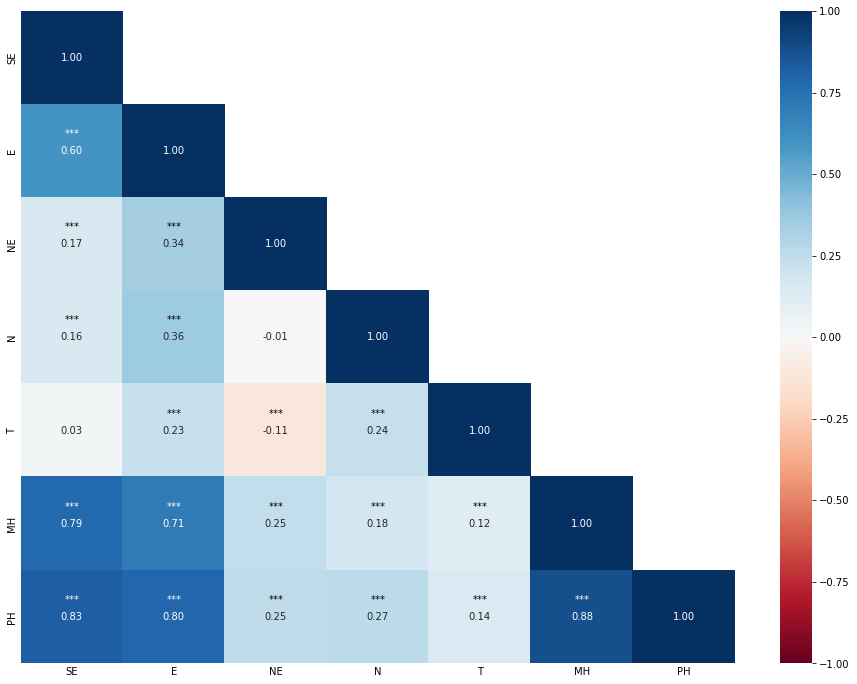

In [42]:
df_coor=pd.concat([df_Domain_Score_Z, df_Z[['MH','PH']]], axis=1).corr()
fig = plt.figure(figsize=(16,12))
ax1 = plt.gca()

#构造mask，去除重复数据显示
mask = np.zeros_like(df_coor)
mask[np.triu_indices_from(mask)] = True
mask2 = mask
mask = (np.flipud(mask)-1)*(-1)
mask = np.rot90(mask,k = -1)

im1 = sns.heatmap(df_coor,annot=True,cmap="RdBu"
, mask=mask#构造mask，去除重复数据显示
,vmax=1,vmin=-1
, fmt='.2f',ax = ax1)

ax1.tick_params(axis = 'both', length=0)

#计算相关性显著性并显示
df = pd.concat([df_Domain_Score_Z, df_Z[['MH','PH']]], axis=1)
rlist = []
plist = []
for i in df.columns.values:
    for j in df.columns.values:
        r,p = pearsonr(df[i],df[j])
        rlist.append(r)
        plist.append(p)

rarr = np.asarray(rlist).reshape(len(df.columns.values),len(df.columns.values))
parr = np.asarray(plist).reshape(len(df.columns.values),len(df.columns.values))
xlist = ax1.get_xticks()
ylist = ax1.get_yticks()

widthx = 0
widthy = -0.15

for m in ax1.get_xticks():
    for n in ax1.get_yticks():
        pv = (parr[int(m),int(n)])
        rv = (rarr[int(m),int(n)])
        if mask2[int(m),int(n)]<1.:
            if abs(rv) > 0.5:
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'white')
                if  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'white')
                if  pv< 0.001:
                    print([int(m),int(n)])
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'white')
            else: 
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'k')
                elif  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'k')
                elif  pv< 0.001:
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'k')
#plt.savefig(r'Z:\GJ\pearsonr\fig\r_demo.png',dpi=600)
plt.show()

## Domain Weight

In [43]:
data_Domain_weight = pd.concat([df_Domain_Score_Z, df_Z[['MH','PH']]], axis=1).corr().iloc[:-2,-2:].round(decimals=2)
data_Domain_weight['Averge_Domain_Weight'] = ((data_Domain_weight['MH']+data_Domain_weight['PH'])/2).round(decimals=2)
data_Domain_weight

,MH,PH,Averge_Domain_Weight
SE,0.79,0.83,0.81
E,0.71,0.80,0.76
NE,0.25,0.25,0.25
N,0.18,0.27,0.22
T,0.12,0.14,0.13


In [44]:
data_Domain_weight['Final_Domain_Weight'] = (data_Domain_weight['Averge_Domain_Weight']/data_Domain_weight['Averge_Domain_Weight'].sum()).round(decimals=2)
data_Domain_weight

,MH,PH,Averge_Domain_Weight,Final_Domain_Weight
SE,0.79,0.83,0.81,0.37
E,0.71,0.80,0.76,0.35
NE,0.25,0.25,0.25,0.12
N,0.18,0.27,0.22,0.10
T,0.12,0.14,0.13,0.06


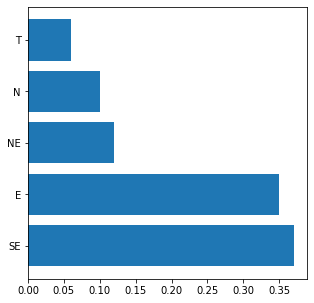

In [45]:
plot, ax = plt.subplots(1,1,figsize = (5,5))
plt.barh(data_Domain_weight.index, data_Domain_weight.Final_Domain_Weight)
plt.show()

In [46]:
data_Domain_weight['Final_Domain_Weight'].sum()

1.0

## Healthy Corridor Index

In [47]:
df_Domain_Score_Z.head()

,SE,E,NE,N,T
0,-0.993065,-0.436942,-0.639559,-1.808164,-0.869665
1,0.683191,-0.373747,0.220499,-0.473677,-0.907869
2,-0.328579,-0.728554,-1.458504,-0.348938,-0.088118
3,-1.383115,-0.685025,-1.077243,-0.944268,0.258373
4,-2.647866,-1.152703,-0.361006,-1.086366,-0.334892


In [48]:
df_HCI = pd.DataFrame()
for i in df_Domain_Score_Z.columns:
    df_HCI[i] = df_Domain_Score_Z[i]*data_Domain_weight.loc[i, 'Final_Domain_Weight']
df_HCI

,SE,E,NE,N,T
0,-0.367434,-0.152930,-0.076747,-0.180816,-0.052180
1,0.252781,-0.130812,0.026460,-0.047368,-0.054472
2,-0.121574,-0.254994,-0.175020,-0.034894,-0.005287
3,-0.511753,-0.239759,-0.129269,-0.094427,0.015502
4,-0.979710,-0.403446,-0.043321,-0.108637,-0.020093
...,...,...,...,...,...
2016,0.356332,-0.032961,-0.147478,-0.007960,-0.102692
2017,0.139306,-0.051842,-0.078751,-0.077425,-0.106378
2018,-0.275297,-0.412172,-0.066895,0.043014,-0.068725
2019,-0.010180,-0.185057,-0.069549,0.150981,-0.097935


In [49]:
df_HCI['HCI'] = df_HCI.sum(axis=1)
df_HCI

,SE,E,NE,N,T,HCI
0,-0.367434,-0.152930,-0.076747,-0.180816,-0.052180,-0.830107
1,0.252781,-0.130812,0.026460,-0.047368,-0.054472,0.046589
2,-0.121574,-0.254994,-0.175020,-0.034894,-0.005287,-0.591770
3,-0.511753,-0.239759,-0.129269,-0.094427,0.015502,-0.959705
4,-0.979710,-0.403446,-0.043321,-0.108637,-0.020093,-1.555207
...,...,...,...,...,...,...
2016,0.356332,-0.032961,-0.147478,-0.007960,-0.102692,0.065240
2017,0.139306,-0.051842,-0.078751,-0.077425,-0.106378,-0.175091
2018,-0.275297,-0.412172,-0.066895,0.043014,-0.068725,-0.780075
2019,-0.010180,-0.185057,-0.069549,0.150981,-0.097935,-0.211740


In [50]:
df_HCI.describe()

,SE,E,NE,N,T,HCI
count,2.021000e+03,2.021000e+03,2021.000000,2.021000e+03,2021.000000,2021.000000
mean,2.109479e-17,-7.031596e-18,0.000000,3.076323e-18,0.000000,0.000000
std,3.700916e-01,3.500866e-01,0.120030,1.000247e-01,0.060015,0.731779
min,-2.017995e+00,-6.077918e-01,-0.328651,-3.194926e-01,-0.118636,-2.399111
25%,-2.133287e-01,-2.490471e-01,-0.088622,-6.774893e-02,-0.035818,-0.461179
50%,6.255909e-02,-8.393388e-02,-0.002202,-6.138187e-03,-0.009979,-0.028919
75%,2.766356e-01,1.630441e-01,0.083314,6.429263e-02,0.024649,0.393543
max,6.723394e-01,1.078760e+00,0.528852,4.601638e-01,0.511068,1.984664


In [51]:
# Z-score transform
HCI_scaler = StandardScaler().fit(df_HCI)     
HCI_scale = HCI_scaler.transform(df_HCI) 
df_HCI_Score_Z = pd.DataFrame(HCI_scale)
df_HCI_Score_Z.columns = df_HCI.columns
df_HCI_Score_Z = df_HCI_Score_Z[['HCI']]
df_HCI_Score_Z.head()

,HCI
0,-1.134648
1,0.063681
2,-0.808872
3,-1.311792
4,-2.125766


In [52]:
df_HCI_Score_Z.describe()

,HCI
count,2021.000000
mean,0.000000
std,1.000247
min,-3.279273
25%,-0.630371
50%,-0.039529
75%,0.537922
max,2.712777


## Combine all the Data

In [53]:
HCI = pd.concat([df_HCI_Score_Z, df_Domain_Score_Z, df_Z], axis=1).set_index(data.index)
HCI.head()

,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH
GeoID,,,,,,,,,,,,,,,,,,,,,,,
36005000200,-1.134648,-0.993065,-0.436942,-0.639559,-1.808164,-0.869665,-1.657983,0.172613,-0.691800,0.193459,-0.290903,-1.152132,-0.018696,-0.903358,-0.303825,-0.189181,-0.520349,-1.734872,-0.904856,-0.857316,-0.141438,-0.004565,-0.233467
36005000400,0.063681,0.683191,-0.373747,0.220499,-0.473677,-0.907869,0.063621,0.493525,0.774315,0.528897,-0.340031,-0.347093,1.126947,-1.024372,-0.187446,0.000983,-0.416536,-0.294080,-1.036481,-0.887279,-0.071964,0.521571,0.525959
36005001600,-0.808872,-0.328579,-0.728554,-1.458504,-0.348938,-0.088118,0.393792,0.232784,-0.912197,0.054909,-0.826395,0.468357,-0.955509,-1.024743,-0.336185,-0.236387,-0.555999,0.014699,-0.970951,-0.660838,1.292362,-0.741154,-1.226564
36005001900,-1.311792,-1.383115,-0.685025,-1.077243,-0.944268,0.258373,-0.997642,-1.452004,-1.400902,0.507021,-0.526716,-1.311752,-1.002437,-0.031798,-1.003038,-0.236387,-1.851376,0.131079,0.898572,0.404112,-0.658561,-0.951608,-0.379511
36005002000,-2.125766,-2.647866,-1.152703,-0.361006,-1.086366,-0.334892,-2.931498,-0.288698,-2.550796,0.346594,-1.322585,0.846587,0.366706,-0.881201,-0.445692,-0.236387,-0.278779,-1.025024,-1.127284,-0.796684,1.065338,-2.319559,-2.570165


In [54]:
HCI.describe()

,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH
count,2021.000000,2.021000e+03,2.021000e+03,2021.000000,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03
mean,0.000000,2.812638e-17,-5.625276e-17,0.000000,3.867378e-17,1.406319e-17,-8.437915e-17,-3.269692e-16,5.625276e-17,-9.844234e-17,5.625276e-17,-1.177792e-16,-2.081352e-15,1.036457e-14,-1.209434e-15,-2.812638e-17,-3.164218e-16,2.882954e-16,1.476635e-16,-7.031596e-18,-5.625276e-17,-1.350066e-15,9.844234e-17
std,1.000247,1.000247e+00,1.000247e+00,1.000247,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00,1.000247e+00
min,-3.279273,-5.454040e+00,-1.736548e+00,-2.738756,-3.194926e+00,-1.977274e+00,-7.695389e+00,-6.907507e+00,-5.176389e+00,-4.568295e+00,-1.617351e+00,-2.189662e+00,-2.540414e+00,-2.900638e+00,-1.451301e+00,-2.363872e-01,-2.456357e+00,-2.612233e+00,-1.703237e+00,-1.010726e+00,-1.608197e+00,-3.933040e+00,-3.826140e+00
25%,-0.630371,-5.765640e-01,-7.115630e-01,-0.738519,-6.774893e-01,-5.969621e-01,-4.080514e-01,-4.692107e-01,-5.384808e-01,-5.576289e-01,-7.281398e-01,-6.975623e-01,-7.200377e-01,-8.334393e-01,-8.240498e-01,-2.363872e-01,-6.313053e-01,-6.937932e-01,-7.285596e-01,-5.096434e-01,-6.226198e-01,-5.306997e-01,-5.255547e-01
50%,-0.039529,1.690786e-01,-2.398111e-01,-0.018347,-6.138187e-02,-1.663218e-01,2.287062e-01,1.726132e-01,2.664453e-01,1.934595e-01,-2.417758e-01,7.277724e-02,-1.012139e-01,2.957598e-01,-1.605249e-01,-2.363872e-01,-1.029108e-01,-5.027740e-02,-2.409072e-01,-2.150568e-01,-2.007565e-01,1.708139e-01,8.782850e-02
75%,0.537922,7.476637e-01,4.658403e-01,0.694281,6.429263e-01,4.108192e-01,6.767949e-01,7.141522e-01,7.455681e-01,8.132898e-01,4.656628e-01,8.396468e-01,6.104608e-01,9.143345e-01,6.668776e-01,-2.363872e-01,4.983276e-01,6.550796e-01,4.777702e-01,2.254658e-01,3.553919e-01,6.618733e-01,5.843768e-01
max,2.712777,1.817134e+00,3.082171e+00,4.407101,4.601638e+00,8.517793e+00,1.525805e+00,1.516432e+00,1.473835e+00,1.316446e+00,3.030128e+00,1.280337e+00,4.972238e+00,1.145405e+00,3.347883e+00,1.332207e+01,6.172885e+00,3.219501e+00,5.258263e+00,1.458403e+01,4.782545e+00,2.135052e+00,2.395318e+00


In [55]:
bins=[HCI['HCI'].quantile(0)-1
      , HCI['HCI'].quantile(0.2)
      , HCI['HCI'].quantile(0.4)
      , HCI['HCI'].quantile(0.6)
      , HCI['HCI'].quantile(0.8)
      ,HCI['HCI'].quantile(1)+1]

HCI['HCI_Class'] = pd.cut(HCI['HCI'], bins=bins, labels=['very_unhealthy','unhealthy','moderate','healthy','very healthy'])
HCI.head()

,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH,HCI_Class
GeoID,,,,,,,,,,,,,,,,,,,,,,,,
36005000200,-1.134648,-0.993065,-0.436942,-0.639559,-1.808164,-0.869665,-1.657983,0.172613,-0.691800,0.193459,-0.290903,-1.152132,-0.018696,-0.903358,-0.303825,-0.189181,-0.520349,-1.734872,-0.904856,-0.857316,-0.141438,-0.004565,-0.233467,very_unhealthy
36005000400,0.063681,0.683191,-0.373747,0.220499,-0.473677,-0.907869,0.063621,0.493525,0.774315,0.528897,-0.340031,-0.347093,1.126947,-1.024372,-0.187446,0.000983,-0.416536,-0.294080,-1.036481,-0.887279,-0.071964,0.521571,0.525959,moderate
36005001600,-0.808872,-0.328579,-0.728554,-1.458504,-0.348938,-0.088118,0.393792,0.232784,-0.912197,0.054909,-0.826395,0.468357,-0.955509,-1.024743,-0.336185,-0.236387,-0.555999,0.014699,-0.970951,-0.660838,1.292362,-0.741154,-1.226564,very_unhealthy
36005001900,-1.311792,-1.383115,-0.685025,-1.077243,-0.944268,0.258373,-0.997642,-1.452004,-1.400902,0.507021,-0.526716,-1.311752,-1.002437,-0.031798,-1.003038,-0.236387,-1.851376,0.131079,0.898572,0.404112,-0.658561,-0.951608,-0.379511,very_unhealthy
36005002000,-2.125766,-2.647866,-1.152703,-0.361006,-1.086366,-0.334892,-2.931498,-0.288698,-2.550796,0.346594,-1.322585,0.846587,0.366706,-0.881201,-0.445692,-0.236387,-0.278779,-1.025024,-1.127284,-0.796684,1.065338,-2.319559,-2.570165,very_unhealthy


In [56]:
HCI.groupby('HCI_Class').count()

,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH
HCI_Class,,,,,,,,,,,,,,,,,,,,,,,
very_unhealthy,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405
unhealthy,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404
moderate,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404
healthy,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404
very healthy,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404


# Validation

## OLS model

In [ ]:
est = sm.OLS(HCI['MH'], sm.add_constant(HCI['HCI'])).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                     MH   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3942.
Date:                Mon, 18 Jul 2022   Prob (F-statistic):               0.00
Time:                        05:24:34   Log-Likelihood:                -1773.7
No. Observations:                2021   AIC:                             3551.
Df Residuals:                    2019   BIC:                             3563.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.349e-15      0.013  -1.04e-13      1.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
est = sm.OLS(HCI['PH'], sm.add_constant(HCI['HCI'])).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                     PH   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     7653.
Date:                Mon, 18 Jul 2022   Prob (F-statistic):               0.00
Time:                        05:24:36   Log-Likelihood:                -1284.5
No. Observations:                2021   AIC:                             2573.
Df Residuals:                    2019   BIC:                             2584.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.385e-17      0.010   3.33e-15      1.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
for i in ['SE','E','NE','N', 'T']:
    est = sm.OLS(HCI['PH'], sm.add_constant(HCI[i])).fit()
    print(est.summary())
    print('***'*30)
    print('***'*30)

                            OLS Regression Results                            
Dep. Variable:                     PH   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     4371.
Date:                Mon, 18 Jul 2022   Prob (F-statistic):               0.00
Time:                        05:24:38   Log-Likelihood:                -1703.4
No. Observations:                2021   AIC:                             3411.
Df Residuals:                    2019   BIC:                             3422.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.385e-17      0.013   2.71e-15      1.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Other Health Outcomes

In [57]:
Health_Outcomes = pd.read_csv('./Data/Processed_Data/Domain/Health_Outcomes.csv', index_col=0).set_index('GeoID')
Health_Outcomes.head()

,ARTHRITIS,BPHIGH,CANCER,CASTHMA,CHD,COPD,DEPRESSION,DIABETES,HIGHCHOL,KIDNEY,OBESITY,STROKE,TEETHLOST,TotalPopulation
GeoID,,,,,,,,,,,,,,
36005000100,11.4,28.6,2.1,11.1,3.8,5.5,15.1,9.4,22.1,2.3,34.5,2.7,29.4,11091.0
36005000200,18.0,30.3,4.9,10.4,5.2,5.2,15.2,13.6,30.1,3.3,31.8,3.1,15.5,4334.0
36005000400,15.6,26.8,4.5,9.8,3.9,3.9,14.5,11.0,28.0,2.7,30.2,2.4,10.6,5503.0
36005001600,22.2,35.8,5.7,11.8,7.0,7.3,16.4,16.8,32.2,4.3,35.0,4.3,19.3,5643.0
36005001900,15.2,28.1,3.5,10.8,4.7,5.4,16.6,11.6,26.1,2.9,33.9,2.8,18.6,1917.0


In [58]:
HCI_Disease = HCI.merge(Health_Outcomes, left_index=True, right_index=True)
HCI_Disease.head()

,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH,HCI_Class,ARTHRITIS,BPHIGH,CANCER,CASTHMA,CHD,COPD,DEPRESSION,DIABETES,HIGHCHOL,KIDNEY,OBESITY,STROKE,TEETHLOST,TotalPopulation
GeoID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36005000200,-1.134648,-0.993065,-0.436942,-0.639559,-1.808164,-0.869665,-1.657983,0.172613,-0.691800,0.193459,-0.290903,-1.152132,-0.018696,-0.903358,-0.303825,-0.189181,-0.520349,-1.734872,-0.904856,-0.857316,-0.141438,-0.004565,-0.233467,very_unhealthy,18.0,30.3,4.9,10.4,5.2,5.2,15.2,13.6,30.1,3.3,31.8,3.1,15.5,4334.0
36005000400,0.063681,0.683191,-0.373747,0.220499,-0.473677,-0.907869,0.063621,0.493525,0.774315,0.528897,-0.340031,-0.347093,1.126947,-1.024372,-0.187446,0.000983,-0.416536,-0.294080,-1.036481,-0.887279,-0.071964,0.521571,0.525959,moderate,15.6,26.8,4.5,9.8,3.9,3.9,14.5,11.0,28.0,2.7,30.2,2.4,10.6,5503.0
36005001600,-0.808872,-0.328579,-0.728554,-1.458504,-0.348938,-0.088118,0.393792,0.232784,-0.912197,0.054909,-0.826395,0.468357,-0.955509,-1.024743,-0.336185,-0.236387,-0.555999,0.014699,-0.970951,-0.660838,1.292362,-0.741154,-1.226564,very_unhealthy,22.2,35.8,5.7,11.8,7.0,7.3,16.4,16.8,32.2,4.3,35.0,4.3,19.3,5643.0
36005001900,-1.311792,-1.383115,-0.685025,-1.077243,-0.944268,0.258373,-0.997642,-1.452004,-1.400902,0.507021,-0.526716,-1.311752,-1.002437,-0.031798,-1.003038,-0.236387,-1.851376,0.131079,0.898572,0.404112,-0.658561,-0.951608,-0.379511,very_unhealthy,15.2,28.1,3.5,10.8,4.7,5.4,16.6,11.6,26.1,2.9,33.9,2.8,18.6,1917.0
36005002000,-2.125766,-2.647866,-1.152703,-0.361006,-1.086366,-0.334892,-2.931498,-0.288698,-2.550796,0.346594,-1.322585,0.846587,0.366706,-0.881201,-0.445692,-0.236387,-0.278779,-1.025024,-1.127284,-0.796684,1.065338,-2.319559,-2.570165,very_unhealthy,23.3,38.0,4.9,13.7,7.8,9.8,18.6,19.1,32.0,4.8,38.9,5.3,29.0,8731.0


In [59]:
est = sm.OLS(HCI_Disease['OBESITY'], sm.add_constant(HCI_Disease['HCI'])).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                OBESITY   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     2195.
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        01:01:25   Log-Likelihood:                -5810.4
No. Observations:                2021   AIC:                         1.162e+04
Df Residuals:                    2019   BIC:                         1.164e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3409      0.095    275.956      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [60]:
HCI_Disease.columns

Index(['HCI', 'SE', 'E', 'NE', 'N', 'T', 'SE_Unemploy', 'SE_Insurance',
       'SE_Poverty', 'SE_English', 'E_Advance', 'E_PreS', 'NE_Tem', 'NE_Ozone',
       'NE_PM25', 'N_HFood', 'N_TreeD', 'N_LandUseMix', 'T_WalkVSDrive',
       'T_Transit', 'T_NodeD', 'MH', 'PH', 'HCI_Class', 'ARTHRITIS', 'BPHIGH',
       'CANCER', 'CASTHMA', 'CHD', 'COPD', 'DEPRESSION', 'DIABETES',
       'HIGHCHOL', 'KIDNEY', 'OBESITY', 'STROKE', 'TEETHLOST',
       'TotalPopulation'],
      dtype='object')

In [61]:
Disease = HCI.merge(Health_Outcomes, left_index=True, right_index=True)
Disease.head()

,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH,HCI_Class,ARTHRITIS,BPHIGH,CANCER,CASTHMA,CHD,COPD,DEPRESSION,DIABETES,HIGHCHOL,KIDNEY,OBESITY,STROKE,TEETHLOST,TotalPopulation
GeoID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36005000200,-1.134648,-0.993065,-0.436942,-0.639559,-1.808164,-0.869665,-1.657983,0.172613,-0.691800,0.193459,-0.290903,-1.152132,-0.018696,-0.903358,-0.303825,-0.189181,-0.520349,-1.734872,-0.904856,-0.857316,-0.141438,-0.004565,-0.233467,very_unhealthy,18.0,30.3,4.9,10.4,5.2,5.2,15.2,13.6,30.1,3.3,31.8,3.1,15.5,4334.0
36005000400,0.063681,0.683191,-0.373747,0.220499,-0.473677,-0.907869,0.063621,0.493525,0.774315,0.528897,-0.340031,-0.347093,1.126947,-1.024372,-0.187446,0.000983,-0.416536,-0.294080,-1.036481,-0.887279,-0.071964,0.521571,0.525959,moderate,15.6,26.8,4.5,9.8,3.9,3.9,14.5,11.0,28.0,2.7,30.2,2.4,10.6,5503.0
36005001600,-0.808872,-0.328579,-0.728554,-1.458504,-0.348938,-0.088118,0.393792,0.232784,-0.912197,0.054909,-0.826395,0.468357,-0.955509,-1.024743,-0.336185,-0.236387,-0.555999,0.014699,-0.970951,-0.660838,1.292362,-0.741154,-1.226564,very_unhealthy,22.2,35.8,5.7,11.8,7.0,7.3,16.4,16.8,32.2,4.3,35.0,4.3,19.3,5643.0
36005001900,-1.311792,-1.383115,-0.685025,-1.077243,-0.944268,0.258373,-0.997642,-1.452004,-1.400902,0.507021,-0.526716,-1.311752,-1.002437,-0.031798,-1.003038,-0.236387,-1.851376,0.131079,0.898572,0.404112,-0.658561,-0.951608,-0.379511,very_unhealthy,15.2,28.1,3.5,10.8,4.7,5.4,16.6,11.6,26.1,2.9,33.9,2.8,18.6,1917.0
36005002000,-2.125766,-2.647866,-1.152703,-0.361006,-1.086366,-0.334892,-2.931498,-0.288698,-2.550796,0.346594,-1.322585,0.846587,0.366706,-0.881201,-0.445692,-0.236387,-0.278779,-1.025024,-1.127284,-0.796684,1.065338,-2.319559,-2.570165,very_unhealthy,23.3,38.0,4.9,13.7,7.8,9.8,18.6,19.1,32.0,4.8,38.9,5.3,29.0,8731.0


In [62]:
Disease['OBESITY'].mean()

26.340870856011875

In [63]:
HCI_Disease_G = HCI_Disease.groupby('HCI_Class').mean()

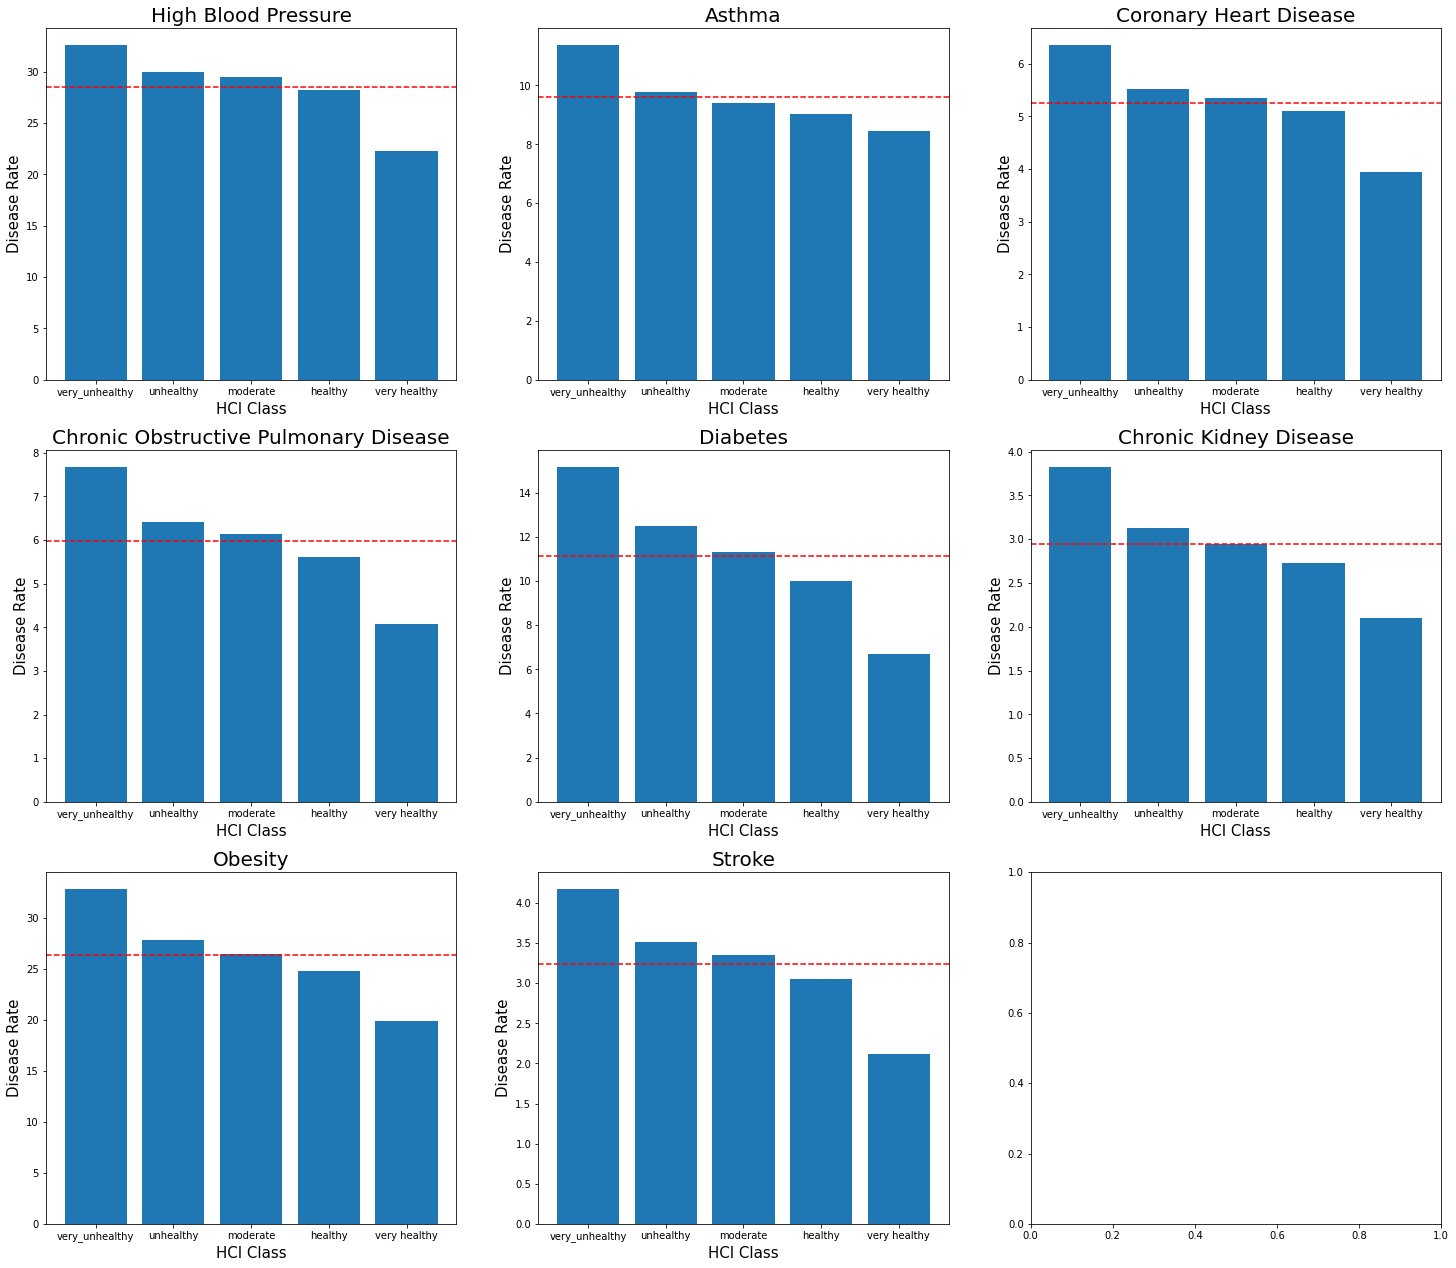

In [75]:
fig, ax = plt.subplots(3,3, figsize=(25,22))

labels = ['High Blood Pressure', 'Asthma', 'Coronary Heart Disease'
         , 'Chronic Obstructive Pulmonary Disease', 'Diabetes', 'Chronic Kidney Disease'
         , 'Obesity', 'Stroke']

for i,j in enumerate(['BPHIGH', 'CASTHMA', 'CHD'
                      , 'COPD', 'DIABETES', 'KIDNEY'
                      , 'OBESITY','STROKE']):
    
    ax[i//3][i%3].bar(x=HCI_Disease_G.index, height=HCI_Disease_G[j])
    ax[i//3][i%3].axhline(y=Disease[j].mean(), ls='--', color='r')
    label = labels[i]
    ax[i//3][i%3].set_title(label, fontsize=20)
    ax[i//3][i%3].set_xlabel('HCI Class', fontsize=15)
    ax[i//3][i%3].set_ylabel('Disease Rate', fontsize=15)

plt.show()

In [ ]:
fig.savefig('./Image/Disease_Compare.jpg', dpi=600,bbox_inches='tight')

In [ ]:
HCI_Disease

,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,...,CHD,COPD,DEPRESSION,DIABETES,HIGHCHOL,KIDNEY,OBESITY,STROKE,TEETHLOST,TotalPopulation
GeoID,,,,,,,,,,,,,,,,,,,,,
36005000200,-1.134648,-0.993065,-0.436942,-0.639559,-1.808164,-0.869665,-1.657983,0.172613,-0.691800,0.193459,...,5.2,5.2,15.2,13.6,30.1,3.3,31.8,3.1,15.5,4334.0
36005000400,0.063681,0.683191,-0.373747,0.220499,-0.473677,-0.907869,0.063621,0.493525,0.774315,0.528897,...,3.9,3.9,14.5,11.0,28.0,2.7,30.2,2.4,10.6,5503.0
36005001600,-0.808872,-0.328579,-0.728554,-1.458504,-0.348938,-0.088118,0.393792,0.232784,-0.912197,0.054909,...,7.0,7.3,16.4,16.8,32.2,4.3,35.0,4.3,19.3,5643.0
36005001900,-1.311792,-1.383115,-0.685025,-1.077243,-0.944268,0.258373,-0.997642,-1.452004,-1.400902,0.507021,...,4.7,5.4,16.6,11.6,26.1,2.9,33.9,2.8,18.6,1917.0
36005002000,-2.125766,-2.647866,-1.152703,-0.361006,-1.086366,-0.334892,-2.931498,-0.288698,-2.550796,0.346594,...,7.8,9.8,18.6,19.1,32.0,4.8,38.9,5.3,29.0,8731.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36085030301,0.089175,0.963059,-0.094174,-1.228984,-0.079600,-1.711541,0.511710,0.413297,1.013877,0.412223,...,4.6,5.6,15.9,9.7,28.4,2.3,29.7,2.6,14.1,4929.0
36085030302,-0.239327,0.376501,-0.148121,-0.656262,-0.774252,-1.772965,0.228706,0.493525,0.074796,0.725784,...,4.3,5.4,15.4,10.3,27.1,2.4,31.7,2.6,13.9,6369.0
36085031901,-1.066261,-0.744045,-1.177634,-0.557457,0.430137,-1.145416,0.134372,0.754266,-1.822530,0.674739,...,5.6,8.3,17.9,14.8,26.5,3.5,41.1,4.2,33.5,3265.0


# Plot HCI

In [76]:
# geo data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson')
ct2010.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,36085000900,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,36061009800,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
2,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,36061010200,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
3,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,36061010400,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."
4,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,36061011300,"POLYGON ((-73.98412 40.75484, -73.98460 40.754..."


In [77]:
HCI_Geo = HCI.merge(ct2010, left_index=True, right_on='GeoID')
HCI_Geo = gpd.GeoDataFrame(HCI_Geo, geometry=HCI_Geo.geometry, crs=4326)
len(HCI_Geo)

2021

In [78]:
HCI_Geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [79]:
HCI_Geo[HCI_Geo.HCI_Class.isnull()]

,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH,HCI_Class,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID,geometry


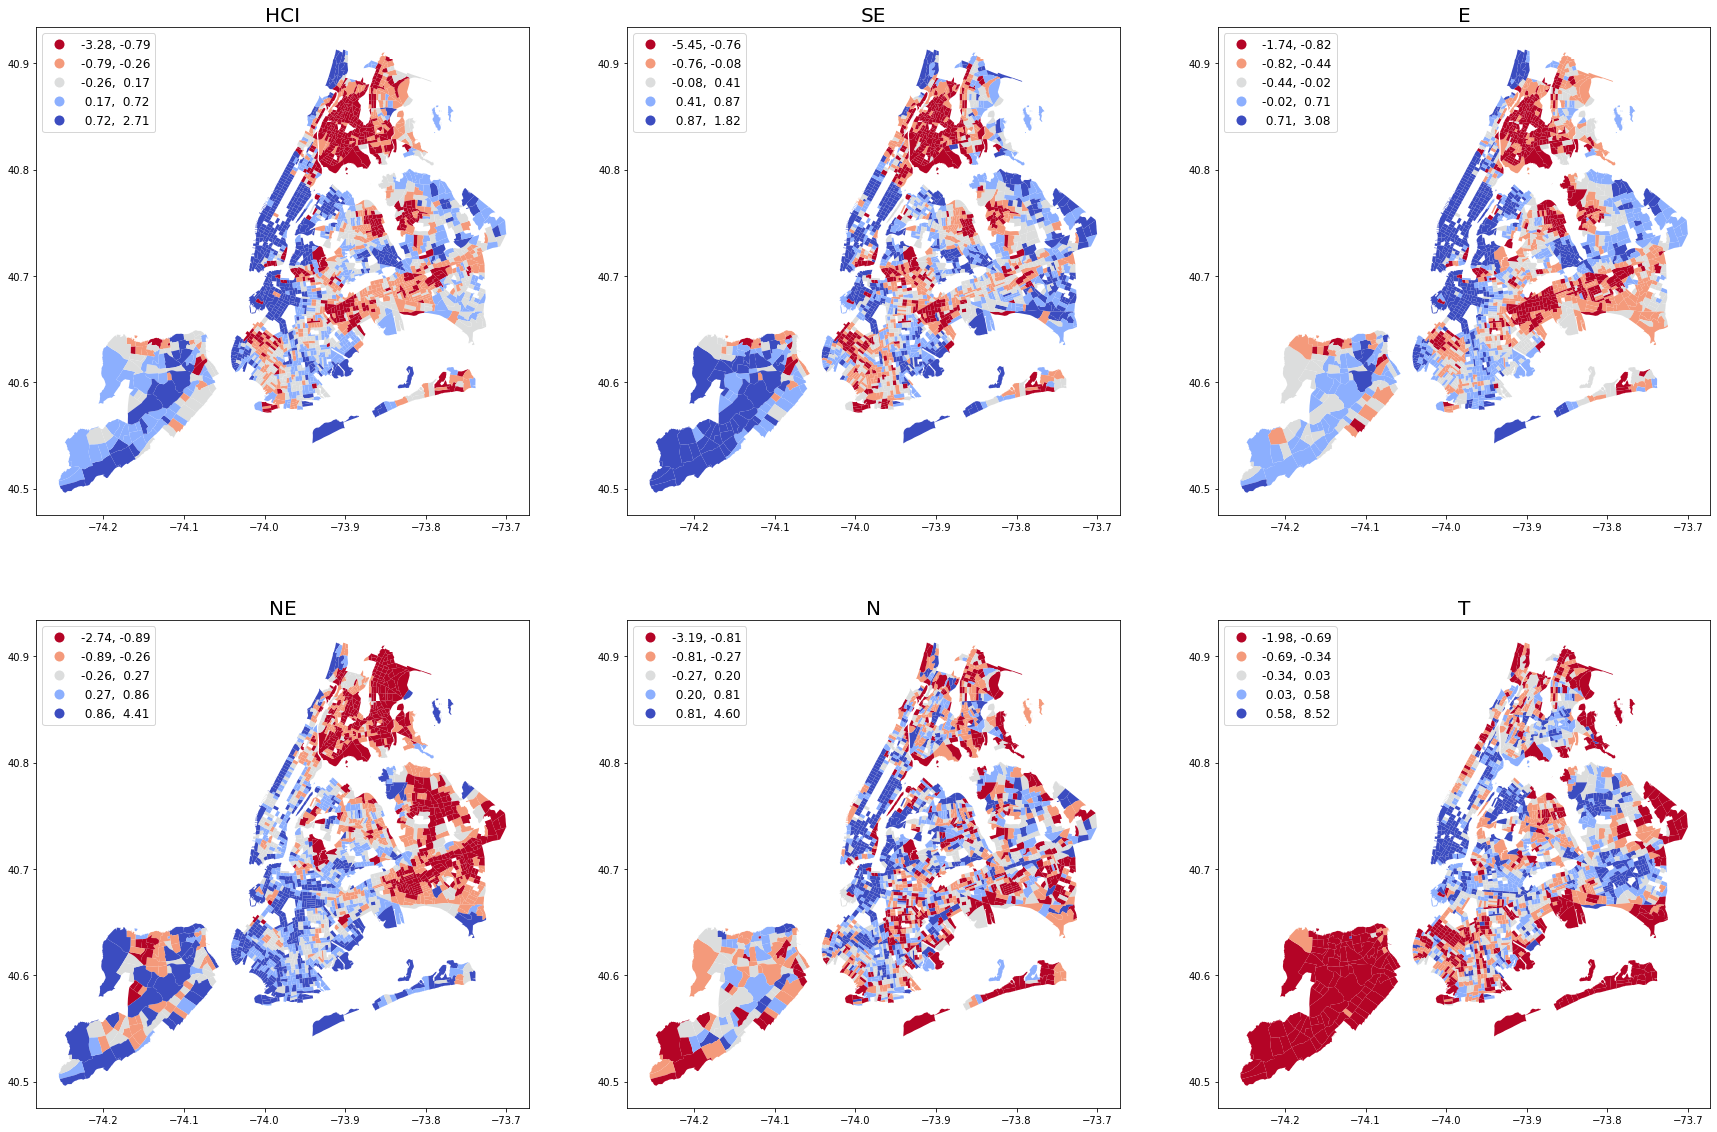

In [81]:
fig, ax = plt.subplots(2,3, figsize=(30,20))

a = ['HCI', 'SE', 'E', 'NE', 'N', 'T']

for i,j in enumerate(a):
    HCI_Geo.plot(column=j, cmap='coolwarm_r', ax=ax[i//3][i%3],
                              legend=True, scheme='Quantiles', k=5,legend_kwds={'loc':'upper left','fontsize':'large'},
                              #,figsize=(10,10)
                )
    
    label = j
    ax[i//3][i%3].set_title(label, fontsize=20)
    
plt.show()

In [ ]:
fig.savefig('./Image/HCI_Plot1.jpg', dpi=600,bbox_inches='tight')

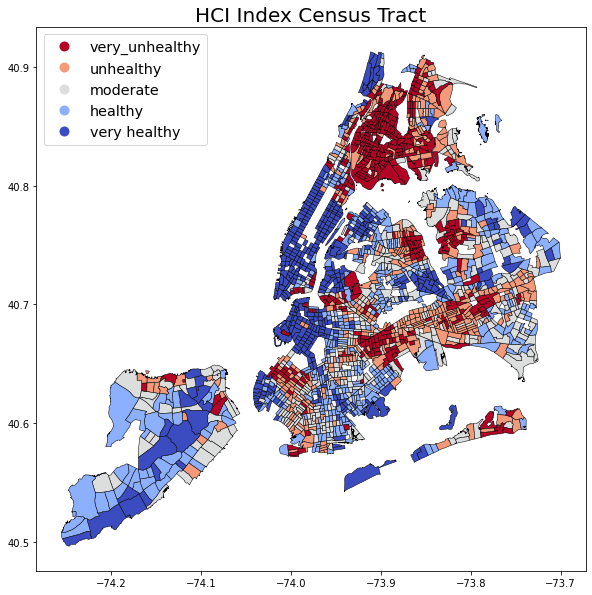

In [92]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

HCI_Geo.plot(column='HCI_Class', cmap='coolwarm_r', ax=ax
                          ,legend=True
                          ,legend_kwds={'loc':'upper left','fontsize':'x-large'}
                          ,edgecolor='black', linewidth=0.5
                          ,figsize=(10,10))

ax.set_title('HCI Index Census Tract', fontsize=20)

plt.show()

In [ ]:
||# Bottom Five
HCI_Geo.sort_values(by='HCI')[['HCI','boro_name','ntaname']].head(5)

,HCI,boro_name,ntaname
507,-3.279273,Brooklyn,Brownsville
2124,-3.178888,Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill
2134,-2.986319,Brooklyn,Brownsville
2098,-2.830226,Brooklyn,Carroll Gardens-Columbia Street-Red Hook
985,-2.818810,Brooklyn,Prospect Lefferts Gardens-Wingate


In [ ]:
# Top Five
HCI_Geo.sort_values(by='HCI', ascending=False)[['HCI','BE','boro_name','ntaname']].head(5)

KeyError: ignored

In [ ]:
HCI_Geo.sort_values(by=['HCI','BE'], ascending=True)[['HCI','BE','boro_name','ntaname']].head(5)

KeyError: ignored

In [ ]:
HCI_Geo.sort_values(by=['N'], ascending=True)[['HCI','N','boro_name','ntaname']].head(5)

,HCI,N,boro_name,ntaname
234,-1.919094,-3.194926,Brooklyn,East New York
2051,-1.590031,-3.004573,Queens,Hammels-Arverne-Edgemere
143,-1.324863,-2.923753,Brooklyn,Sheepshead Bay-Gerritsen Beach-Manhattan Beach
879,-1.077829,-2.809679,Queens,Queens Village
379,-1.090647,-2.771588,Queens,Queens Village


In [ ]:
HCI_Geo.sort_values(by=['T'], ascending=True)[['HCI','N','boro_name','ntaname']].head(5)

,HCI,N,boro_name,ntaname
1420,0.658551,-0.989361,Staten Island,Charleston-Richmond Valley-Tottenville
1273,-1.131822,-0.735449,Staten Island,Grymes Hill-Clifton-Fox Hills
1820,0.949173,-0.798838,Staten Island,Todt Hill-Emerson Hill-Heartland Village-Light...
1898,0.135061,0.061500,Staten Island,Rossville-Woodrow
1796,0.230720,-0.149418,Staten Island,New Springville-Bloomfield-Travis


In [ ]:
HCI_Geo['HCI_Class'] = HCI_Geo['HCI_Class'].astype('str')

In [ ]:
HCI_Geo.to_file('./Data/Final_Data/HCI_CT.geojson', driver='GeoJSON')

In [ ]:
HCI_CT = HCI_CT.to_crs(4326)

In [ ]:
HCI_CT.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
HCI_CT.to_file('./Data/Final_Data/HCI_CT.geojson', driver='GeoJSON')

# CORRIDOR VERSION

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.1.3
Uninstalling matplotlib-3.1.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)


In [ ]:
import matplotlib

In [ ]:
EL_Infrastructure = gpd.read_file('/content/drive/MyDrive/DOT_File/HCI/HCI_Code/Data/Raw_Data/Geo/EL_Space/El-Space_STATIC_20200309.shp')
EL_Infrastructure.head()

,OBJECTID,ELSP_ID,ELST_ID,ELST_ID2,GROUP_ID,ELSP_NAME,BORO,USE_ST,USE_PS,USE_DOT,USE_PRK,USE_PRIV,USE_GOV,USE_LAS,DRN_ISS,SOUND,SOUND_DATE,SOUND_TIME,LITE_TYPE,LITE_HOR,LITE_VER,LITE_DATE,LITE_TIME,PIGN_ISS,RECUR_ISS,WALL_ABUT,WALL_MAT,CLEARANCE,SPAN_LOC,NOTE,CREATED_US,CREATED_DA,LAST_EDITE,LAST_EDI_1,GlobalID,GUID,Shape_STAr,Shape_STLe,geometry
0,1540,0,None,None,None,None,Manhattan,Yes,None,None,None,None,None,None,None,0,None,None,None,0,0,None,None,None,None,None,None,0.0,None,None,JLEE,2019-06-13,JLEE,2019-06-13,{24E01DAC-92C2-4132-82C5-000653FD7EF3},{6C4E7121-2A2C-4D51-81B2-8631210A2553},21191.046829,597.742045,"POLYGON ((991975.758 210103.318, 992060.430 21..."
1,4783,0,None,None,None,None,Bronx,Yes,None,None,None,None,None,None,None,0,None,None,None,0,0,None,None,None,None,None,None,0.0,None,None,JLEE,2019-06-13,JLEE,2019-06-13,{734087F0-8105-4B31-923C-00083C89ABAF},{0D1962D3-6A91-4245-9029-7C1C655D402D},9214.537903,391.824332,"POLYGON ((1016929.900 244579.666, 1016982.452 ..."
2,1313,0,None,None,None,None,Brooklyn,Yes,None,None,None,None,None,None,None,0,None,None,None,0,0,None,None,None,None,None,None,0.0,None,None,JLEE,2019-06-13,JLEE,2019-06-13,{8208A5A1-7162-462B-B704-0011B02C7AC2},{874F9B23-1E0C-4080-99C8-F47D2ECAC3B4},17748.074753,632.671726,"POLYGON ((1006685.764 189828.449, 1006653.384 ..."
3,5108,0,None,None,None,None,Staten Island,None,None,None,None,None,Yes,None,None,0,None,None,None,0,0,None,None,None,None,None,None,0.0,None,None,JLEE,2019-06-13,JLEE,2019-06-13,{5CBA5A4F-E259-4233-92D4-0018FF2587AA},{CB458F66-194C-4FEC-A9B3-996B8C9708D7},29655.817047,727.895024,"POLYGON ((969073.318 159215.936, 969222.302 15..."
4,8048,0,None,None,None,None,Manhattan,Yes,None,None,None,None,None,None,None,0,None,None,None,0,0,None,None,None,None,None,None,0.0,None,None,Esri_Anonymous,2019-07-24,Esri_Anonymous,2019-07-24,{416EE1DE-E40D-4C31-9859-004246186B7E},{00000000-0000-0000-0000-000000000000},2885.600266,222.722341,"POLYGON ((983875.712 196987.797, 983931.114 19..."


In [ ]:
HCI1 = gpd.read_file('/content/drive/MyDrive/DOT_File/HCI/HCI_Code/Data/Raw_Data/Geo/HCI_CORRIDORS_CODED/HCI_CORRIDORS_CODED.shp')
HCI1['StreetCode'] = HCI1['StreetCode'].astype('int')
HCI1.head()

,StreetCode,ELSPACE,NTACode,DISP,UNIQUEFID,UNIQUEFI_1,TOTHCI,BECOMP,NECOMP,HCOMP,SECOMP,BE1Z,BE2Z,BE3Z,BE4Z,BE5Z,NE1Z,NE2Z,NE3Z,NE4Z,H1Z,H2Z,H2Za,H2Zb,H3Z,H3Za,H3Zb,H3Zc,SE1Z,SE2Z,SE3Z,SE4Z,SE4Za,SE4Zb,SE4Zc,geometry
0,110110,0,MN19,1,0,0,0.406430,-0.200167,-0.023561,1.409891,0.439558,-0.593414,0.901898,3.049879,1.448176,-0.292382,0.713356,-0.575253,0.977764,-0.933904,-1.422568,0.893377,-0.692733,-1.094020,1.913727,-1.846968,2.236042,-1.658170,2.667362,-1.262049,-1.681720,1.481826,-1.489892,-1.443127,-1.512460,"LINESTRING (-8234704.466 4975232.739, -8234653..."
1,110110,0,MN20,1,1,1,0.093564,-0.267910,-0.124544,0.099375,0.667337,-0.403227,-0.948980,1.727902,1.448176,-0.292382,0.880559,-0.343324,0.903015,-0.863957,-1.083533,-2.469567,2.588612,2.350522,1.684157,-1.158259,2.236042,-1.658170,0.490336,-0.922745,-1.189596,1.047343,-1.290685,-1.187027,-0.664317,"LINESTRING (-8235463.243 4973855.667, -8235412..."
2,110110,0,MN21,1,2,2,0.517315,0.230373,-0.401644,1.223289,1.017243,0.894680,0.503243,1.400030,0.861592,-0.292382,0.995879,0.629960,0.776675,-0.757410,-1.107750,0.936407,-1.010956,-0.861857,1.625710,-1.269929,1.932792,-1.674410,-0.265895,-1.318600,-1.505962,0.978517,-0.593461,-1.289467,-1.052623,"LINESTRING (-8235966.621 4972944.312, -8235910..."
3,110110,0,MN22,1,3,3,0.399141,0.147883,-0.162279,0.742499,0.868461,1.426599,0.370846,1.032417,0.214532,0.240147,1.066341,-0.114218,0.385969,-0.082960,-0.647631,0.248981,-0.640565,0.142603,1.330884,-0.702049,1.598278,-1.692325,-0.609636,-0.943952,-1.283334,0.636922,-0.560260,-1.135807,-0.214699,"LINESTRING (-8236640.035 4971719.115, -8236620..."
4,110110,0,MN31,1,4,4,0.245477,-0.213938,0.377917,0.078938,0.738993,-0.900324,-0.621752,1.181668,1.448176,-0.185876,0.475111,-1.351620,0.636972,-0.001812,-0.938233,-2.529559,2.708597,2.350522,1.828140,-1.590208,2.236042,-1.658170,0.948657,-1.007571,-1.482527,1.414530,-1.622696,-1.282150,-1.338744,"LINESTRING (-8233669.880 4977095.192, -8233636..."


In [ ]:
LION21A = gpd.read_file('/content/drive/MyDrive/DOT_File/HCI/HCI_Code/Data/Raw_Data/Geo/LION_21A/LION_21A.shp')
LION21A.head()

,OBJECTID,Street,SAFStreetN,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,SpecAddr,FaceCode,SeqNum,StreetCode,SAFStreetC,LGC1,LGC2,LGC3,LGC4,LGC5,LGC6,LGC7,LGC8,LGC9,BOE_LGC,SegmentID,SegCount,LocStatus,LZip,RZip,LBoro,RBoro,L_CD,R_CD,LATOMICPOL,RATOMICPOL,LCT2010,LCT2010Suf,RCT2010,RCT2010Suf,LCB2010,LCB2010Suf,RCB2010,RCB2010Suf,LCT2000,LCT2000Suf,RCT2000,RCT2000Suf,LCB2000,LCB2000Suf,RCB2000,RCB2000Suf,LCT1990,LCT1990Suf,RCT1990,RCT1990Suf,LAssmDist,LElectDist,RAssmDist,RElectDist,SplitElect,LSchlDist,RSchlDist,SplitSchl,LSubSect,RSubSect,SanDistInd,MapFrom,MapTo,BoroBndry,MH_RI_Flag,XFrom,YFrom,XTo,YTo,ArcCenterX,ArcCenterY,CurveFlag,Radius,NodeIDFrom,NodeIDTo,NodeLevelF,NodeLevelT,ConParity,Twisted,RW_TYPE,PhysicalID,GenericID,NYPDID,FDNYID,LBlockFace,RBlockFace,LegacyID,Status,StreetWidt,StreetWi_1,StreetWi_2,BikeLane,BIKE_TRAFD,ACTIVE_FLA,POSTED_SPE,Snow_Prior,Number_Tra,Number_Par,Number_Tot,Carto_Disp,FCC,ROW_Type,LLo_Hyphen,LHi_Hyphen,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,L_PD_Servi,R_PD_Servi,TRUCK_ROUT,SHAPE_Leng,geometry
0,1.0,EAST 168 STREET,None,0,U,None,B,None,T,DOT,None,2510,03070,226700,None,01,None,None,None,None,None,None,None,None,1,0078126,1,X,10456,10456,2.0,2.0,203,203,402,101,149,None,185,None,3001,None,2000,None,149,None,137,None,4000,None,1000,None,149,None,137,None,79,040,79,040,None,09,09,None,1B,1B,None,3D,3D,None,None,1010964,241812,1011265,241555,0,0,None,0,0047740,9045677,M,M,None,None,1,35231.0,30694.0,None,None,1422600653,1422602017,0078126,2,34.0,34.0,None,None,None,None,25,S,2,2,4,None,None,None,599,699,596,716,599,699,596,716,2251001000000,None,None,None,396.030947,"LINESTRING (1010964.447 241812.261, 1011265.49..."
1,2.0,WEST 192 STREET,None,0,U,None,B,None,A,DOT,None,7984,00040,274810,None,01,None,None,None,None,None,None,None,None,1,0079796,1,None,10468,10468,2.0,2.0,207,207,302,104,265,None,265,None,2000,None,1004,None,265,None,265,None,3001,None,1003,None,265,None,265,None,78,045,78,059,None,10,10,None,1A,1A,None,3C,3C,None,None,1011577,255024,1011335,255164,0,0,None,0,0048679,0048678,M,M,None,None,1,35248.0,30711.0,None,None,1522607129,1522607721,0079796,2,30.0,30.0,None,None,None,None,25,S,1,2,3,None,None,None,58,98,63,99,58,98,63,99,2798401000000,None,None,None,279.360514,"LINESTRING (1011576.687 255023.583, 1011335.15..."
2,3.0,UNION AVENUE,None,0,U,None,B,None,W,DOT,None,7280,00130,270420,None,01,None,None,None,None,None,None,None,None,1,0077356,4,X,10459,10459,2.0,2.0,203,203,402,401,135,None,131,None,2000,None,3006,None,135,None,131,None,4000,None,4001,None,135,None,131,None,79,046,79,026,None,12,12,None,1A,1A,None,6C,6C,None,None,1011601,239640,1011786,240230,0,0,None,0,0047288,0047822,M,M,None,None,1,35252.0,30715.0,None,None,1422603726,1422604132,0077356,2,34.0,34.0,None,None,None,None,25,S,1,2,3,None,None,None,1017,1079,1016,1084,1017,1079,1016,1084,2728001000000,None,None,None,618.327133,"LINESTRING (1011600.676 239639.743, 1011785.79..."
3,4.0,UNION AVENUE,BEHAGEN PLAYGROUND COMFORT STA,0,U,None,B,None,W,DOT,X,7280,00130,270420,212795,01,None,None,None,None,None,None,None,None,1,0077356,4,X,10459,10459,2.0,2.0,203,203,402,401,135,None,131,None,2000,None,3006,None,135,None,131,None,4000,None,4001,None,135,None,131,None,79,046,79,026,None,12,12,None,1A,1A,None,6C,6C,None,None,1011601,239640,1011786,240230,0,0,None,0,0047288,0047822,M,M,None,None,1,35252.0,30715.0,None,None,1422603726,1422604132,0077356,2,34.0,34.0,None,None,None,None,25,S,1,2,3,None,None,None,None,None,None,None,0,0,0,0,21279502000000X,None,None,None,618.327133,"LINESTRING (1011600.676 239639.743, 1011785.79..."
4,5.0,UNION AVENUE,BEHAGEN PLAYGROUND FIELD NORTH,0,U,None,B,None,W,DOT,X,7280,00130,270420,212795,01,None,None,None,None,None,None,None,None,1,0077356,4,X,10459,10459,2.0,2.0,203,203,402,401,135,None,131,None,2000,None,3006,None,135,None,131,None,4000,None,4001,None,135,None,131,None,79,046,79,026,None,12,12,None,1A,1A,None,6C,6C,None,None,1011601,239640,

In [ ]:
LION21A['Carto_Disp'].unique()

array([None, '20', '10', '30'], dtype=object)

In [ ]:
Corridor = LION21A.copy()
Corridor = Corridor.loc[(Corridor['FeatureTyp'] == '0') | (Corridor['FeatureTyp'] == '1') ] #street and railroad
Corridor = Corridor.loc[(Corridor['RB_Layer']=='G') | (Corridor['RB_Layer']=='B')]
Corridor = Corridor.loc[(Corridor['TrafDir']!='P')] #filter out ped only street
Corridor = Corridor.drop_duplicates(subset=['SegmentID'], keep='first')
len(Corridor)

132385

In [ ]:
EL_segID = Corridor.copy()
EL_segID = gpd.sjoin(EL_Corridor, EL_Infrastructure, how="left", op='intersects')
EL_segID  = EL_segID .dropna(subset=['OBJECTID_right'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
EL_Corridor = Corridor.loc[Corridor['SegmentID'].isin(EL_segID['SegmentID'])]
len(EL_Corridor)

19342

In [ ]:
EL_Corridor.to_file('./Data/Processed_Data/EL_Corridor.geojson', driver='GeoJSON')

In [ ]:
Corridor = Corridor[['OBJECTID','Street', 'StreetCode', 'SegmentID','SHAPE_Leng','geometry','Number_Tot','Number_Tra','Number_Par','Carto_Disp']]
Corridor = Corridor.reset_index(drop=True)
print(Corridor.crs)
Corridor.head()

epsg:2263


,OBJECTID,Street,StreetCode,SegmentID,SHAPE_Leng,geometry,Number_Tot,Number_Tra,Number_Par,Carto_Disp
0,1.0,EAST 168 STREET,226700,0078126,396.030947,"LINESTRING (1010964.447 241812.261, 1011265.49...",4,2,2,None
1,2.0,WEST 192 STREET,274810,0079796,279.360514,"LINESTRING (1011576.687 255023.583, 1011335.15...",3,1,2,None
2,3.0,UNION AVENUE,270420,0077356,618.327133,"LINESTRING (1011600.676 239639.743, 1011785.79...",3,1,2,None
3,8.0,WEST 252 STREET,275175,0174633,16.897559,"LINESTRING (1009942.034 266921.538, 1009926.30...",2,2,None,None
4,9.0,CLAREMONT PARKWAY,219720,0078173,252.183072,"LINESTRING (1010430.311 245241.982, 1010662.46...",6,4,2,None


In [ ]:
Corridor['ELSPACE'] = Corridor['SegmentID'].isin(EL_segID['SegmentID']).astype('int')
Corridor.head()

,OBJECTID,Street,StreetCode,SegmentID,SHAPE_Leng,geometry,Number_Tot,Number_Tra,Number_Par,Carto_Disp,ELSPACE
0,1.0,EAST 168 STREET,226700,0078126,396.030947,"LINESTRING (1010964.447 241812.261, 1011265.49...",4,2,2,None,0
1,2.0,WEST 192 STREET,274810,0079796,279.360514,"LINESTRING (1011576.687 255023.583, 1011335.15...",3,1,2,None,0
2,3.0,UNION AVENUE,270420,0077356,618.327133,"LINESTRING (1011600.676 239639.743, 1011785.79...",3,1,2,None,0
3,8.0,WEST 252 STREET,275175,0174633,16.897559,"LINESTRING (1009942.034 266921.538, 1009926.30...",2,2,None,None,1
4,9.0,CLAREMONT PARKWAY,219720,0078173,252.183072,"LINESTRING (1010430.311 245241.982, 1010662.46...",6,4,2,None,0


# HCI Corridor version

In [ ]:
# sjoin with HCI
Pop = pd.read_csv('/content/drive/MyDrive/DOT_File/HCI/HCI_Code/Data/Processed_Data/Domain/Population.csv')
HCI_CT = gpd.read_file('./Data/Final_Data/HCI_CT.geojson').to_crs(2263)
HCI_CT = HCI_CT.merge(Pop, left_on='GeoID', right_on='LocationID')
HCI_CT.head()

,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH,HCI_Class,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID,geometry,LocationID,TotalPopulation
0,-1.134648,-0.993065,-0.436942,-0.639559,-1.808164,-0.869665,-1.657983,0.172613,-0.691800,0.193459,-0.290903,-1.152132,-0.018696,-0.903358,-0.303825,-0.189181,-0.520349,-1.734872,-0.904856,-0.857316,-0.141438,-0.004565,-0.233467,very_unhealthy,2,2000200,Bronx,I,000200,2,BX09,Soundview-Castle Hill-Clason Point-Harding Park,3709,5.009780e+06,15670.756630,36005000200,"POLYGON ((1023972.528 232680.658, 1023970.431 ...",36005000200,4334.0
1,0.063681,0.683191,-0.373747,0.220499,-0.473677,-0.907869,0.063621,0.493525,0.774315,0.528897,-0.340031,-0.347093,1.126947,-1.024372,-0.187446,0.000983,-0.416536,-0.294080,-1.036481,-0.887279,-0.071964,0.521571,0.525959,moderate,2,2000400,Bronx,I,000400,4,BX09,Soundview-Castle Hill-Clason Point-Harding Park,3709,8.557953e+06,24785.525607,36005000400,"POLYGON ((1026849.274 235548.774, 1026749.976 ...",36005000400,5503.0
2,-0.808872,-0.328579,-0.728554,-1.458504,-0.348938,-0.088118,0.393792,0.232784,-0.912197,0.054909,-0.826395,0.468357,-0.955509,-1.024743,-0.336185,-0.236387,-0.555999,0.014699,-0.970951,-0.660838,1.292362,-0.741154,-1.226564,very_unhealthy,2,2001600,Bronx,E,001600,16,BX09,Soundview-Castle Hill-Clason Point-Harding Park,3709,5.221330e+06,9671.306059,36005001600,"POLYGON ((1024344.112 238946.021, 1024391.333 ...",36005001600,5643.0
3,-1.311792,-1.383115,-0.685025,-1.077243,-0.944268,0.258373,-0.997642,-1.452004,-1.400902,0.507021,-0.526716,-1.311752,-1.002437,-0.031798,-1.003038,-0.236387,-1.851376,0.131079,0.898572,0.404112,-0.658561,-0.951608,-0.379511,very_unhealthy,2,2001900,Bronx,I,001900,19,BX39,Mott Haven-Port Morris,3710,1.796100e+07,29999.480569,36005001900,"MULTIPOLYGON (((1012821.806 229228.265, 101278...",36005001900,1917.0
4,-2.125766,-2.647866,-1.152703,-0.361006,-1.086366,-0.334892,-2.931498,-0.288698,-2.550796,0.346594,-1.322585,0.846587,0.366706,-0.881201,-0.445692,-0.236387,-0.278779,-1.025024,-1.127284,-0.796684,1.065338,-2.319559,-2.570165,very_unhealthy,2,2002000,Bronx,E,002000,20,BX09,Soundview-Castle Hill-Clason Point-Harding Park,3709,4.336906e+06,8383.698264,36005002000,"POLYGON ((1022317.859 237780.872, 1022425.769 ...",36005002000,8731.0


In [ ]:
Corridor_Buffer = Corridor.copy()
Corridor_Buffer['geometry'] = Corridor.buffer(distance=500, cap_style=2)
Corridor_Buffer.head()

,OBJECTID,Street,StreetCode,SegmentID,SHAPE_Leng,geometry,Number_Tot,Number_Tra,Number_Par,Carto_Disp,ELSPACE
0,1.0,EAST 168 STREET,226700,0078126,396.030947,"POLYGON ((1011590.361 241935.029, 1010940.629 ...",4,2,2,None,0
1,2.0,WEST 192 STREET,274810,0079796,279.360514,"POLYGON ((1011083.914 254731.663, 1011586.396 ...",3,1,2,None,0
2,3.0,UNION AVENUE,270420,0077356,618.327133,"POLYGON ((1011308.728 240379.401, 1012262.860 ...",3,1,2,None,0
3,8.0,WEST 252 STREET,275175,0174633,16.897559,"POLYGON ((1009743.791 266462.207, 1010108.814 ...",2,2,None,None,1
4,9.0,CLAREMONT PARKWAY,219720,0078173,252.183072,"POLYGON ((1010857.742 245603.782, 1010467.190 ...",6,4,2,None,0


In [ ]:
HCI_Corridor = gpd.sjoin(Corridor_Buffer, HCI_CT, how="left", op='intersects')
HCI_Corridor = HCI_Corridor.dropna(subset=['HCI'])
HCI_Corridor = HCI_Corridor.groupby('SegmentID').mean().iloc[:,4:].drop(columns=['shape_area',	'shape_leng', 'GeoID', 'LocationID'])
HCI_Corridor.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH,TotalPopulation
SegmentID,,,,,,,,,,,,,,,,,,,,,,,,
0000016,0.594988,1.279486,0.221575,0.594710,-0.807325,-1.771696,0.936215,0.533639,0.975547,1.126851,0.048078,1.280337,0.975611,-1.015208,1.629968,0.462215,-0.089788,-1.036244,-1.171007,-0.950819,-1.608197,0.065587,0.467542,5823.0
0000020,0.463302,1.295876,-0.041663,0.268742,-0.558234,-1.706104,0.853672,0.704124,1.037833,1.035699,-0.057547,0.098802,0.571213,-1.011248,1.592358,0.143569,-0.450176,-0.416990,-1.048513,-0.928544,-1.608197,0.012973,0.525959,5282.0
0000026,0.594988,1.279486,0.221575,0.594710,-0.807325,-1.771696,0.936215,0.533639,0.975547,1.126851,0.048078,1.280337,0.975611,-1.015208,1.629968,0.462215,-0.089788,-1.036244,-1.171007,-0.950819,-1.608197,0.065587,0.467542,5823.0
0000028,0.463302,1.295876,-0.041663,0.268742,-0.558234,-1.706104,0.853672,0.704124,1.037833,1.035699,-0.057547,0.098802,0.571213,-1.011248,1.592358,0.143569,-0.450176,-0.416990,-1.048513,-0.928544,-1.608197,0.012973,0.525959,5282.0
0000029,0.463302,1.295876,-0.041663,0.268742,-0.558234,-1.706104,0.853672,0.704124,1.037833,1.035699,-0.057547,0.098802,0.571213,-1.011248,1.592358,0.143569,-0.450176,-0.416990,-1.048513,-0.928544,-1.608197,0.012973,0.525959,5282.0


In [ ]:
# change value to percentile
HCI_Corridor_Rank = HCI_Corridor.rank(pct=True).multiply(100).round(decimals=0).reset_index()
HCI_Corridor_Rank = HCI_Corridor_Rank.merge(Corridor, on='SegmentID').drop(columns=['OBJECTID']).rename(columns={'TotalPopulation':'PopRank'})
HCI_Corridor_Rank = HCI_Corridor_Rank.merge(HCI_Corridor[['TotalPopulation']].reset_index(), on='SegmentID')
HCI_Corridor_Rank['TotalPopulation'] = HCI_Corridor_Rank['TotalPopulation'].round(decimals=0)
HCI_Corridor_Rank.head()

,SegmentID,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH,PopRank,Street,StreetCode,SHAPE_Leng,geometry,Number_Tot,Number_Tra,Number_Par,Carto_Disp,ELSPACE,TotalPopulation
0,0000016,77.0,95.0,70.0,75.0,17.0,3.0,93.0,64.0,87.0,94.0,62.0,95.0,86.0,24.0,88.0,84.0,58.0,8.0,7.0,5.0,6.0,44.0,70.0,81.0,WARDS POINT AVENUE,554264,133.964408,"LINESTRING (913553.959 123788.919, 913588.251 ...",4,2,2,None,0,5823.0
1,0000020,72.0,95.0,58.0,64.0,26.0,5.0,89.0,73.0,90.0,90.0,57.0,54.0,76.0,25.0,88.0,79.0,38.0,29.0,12.0,8.0,6.0,42.0,74.0,75.0,PERTH AMBOY PLACE,543252,317.926179,"LINESTRING (913868.316 123836.428, 913553.959 ...",1,1,None,None,0,5282.0
2,0000026,77.0,95.0,70.0,75.0,17.0,3.0,93.0,64.0,87.0,94.0,62.0,95.0,86.0,24.0,88.0,84.0,58.0,8.0,7.0,5.0,6.0,44.0,70.0,81.0,WARDS POINT AVENUE,554264,300.667585,"LINESTRING (913469.291 124077.419, 913553.959 ...",4,2,2,None,0,5823.0
3,0000028,72.0,95.0,58.0,64.0,26.0,5.0,89.0,73.0,90.0,90.0,57.0,54.0,76.0,25.0,88.0,79.0,38.0,29.0,12.0,8.0,6.0,42.0,74.0,75.0,WARDS POINT AVENUE,554264,305.247404,"LINESTRING (913353.157 124359.711, 913469.291 ...",4,2,2,None,0,5282.0
4,0000029,72.0,95.0,58.0,64.0,26.0,5.0,89.0,73.0,90.0,90.0,57.0,54.0,76.0,25.0,88.0,79.0,38.0,29.0,12.0,8.0,6.0,42.0,74.0,75.0,AMBOY ROAD,515650,286.446472,"LINESTRING (913639.005 124341.204, 913353.157 ...",4,2,2,20,0,5282.0


In [ ]:
HCI_Corridor_Rank.describe()

,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH,PopRank,SHAPE_Leng,ELSPACE,TotalPopulation
count,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000,126058.000000
mean,49.998168,50.002316,49.999556,50.000714,50.000524,50.001222,50.007933,49.979470,50.006735,50.003070,50.001658,49.997882,49.999968,50.001507,50.002063,50.065018,50.000666,50.000706,50.002824,49.995082,49.946913,50.002324,49.994733,50.002578,271.080224,0.140245,4345.879373
std,28.872613,28.871636,28.868502,28.872036,28.869567,28.869694,28.877597,28.851705,28.875103,28.875193,28.869227,28.832000,28.869715,28.869369,28.870641,24.119048,28.866017,28.871522,28.868696,28.872922,28.922126,28.874925,28.867106,28.871119,221.858328,0.347242,2120.903934
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,2.165537,0.000000,1003.000000
25%,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,34.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,106.198915,0.000000,2942.000000
50%,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,34.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,250.369326,0.000000,3984.000000
75%,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,344.337299,0.000000,5301.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,95.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,5975.379364,1.000000,26588.000000


In [ ]:
HCI_Corridor_Geo = gpd.GeoDataFrame(HCI_Corridor_Rank, geometry=HCI_Corridor_Rank.geometry, crs=2263).to_crs(4326)

In [ ]:
HCI_Corridor_Geo['Number_Tot'] = HCI_Corridor_Geo.Number_Tot.fillna(0).astype('int')
HCI_Corridor_Geo['Number_Tra'] = HCI_Corridor_Geo.Number_Tra.fillna(0).astype('int')
HCI_Corridor_Geo['Number_Par'] = HCI_Corridor_Geo.Number_Par.fillna(0).astype('int')
HCI_Corridor_Geo['Carto_Disp'] =HCI_Corridor_Geo.Carto_Disp.fillna(0).astype('int')

In [ ]:
HCI_Corridor_Geo.dtypes

SegmentID            object
HCI                 float64
SE                  float64
E                   float64
NE                  float64
N                   float64
T                   float64
SE_Unemploy         float64
SE_Insurance        float64
SE_Poverty          float64
SE_English          float64
E_Advance           float64
E_PreS              float64
NE_Tem              float64
NE_Ozone            float64
NE_PM25             float64
N_HFood             float64
N_TreeD             float64
N_LandUseMix        float64
T_WalkVSDrive       float64
T_Transit           float64
T_NodeD             float64
MH                  float64
PH                  float64
PopRank             float64
Street               object
StreetCode           object
SHAPE_Leng          float64
geometry           geometry
Number_Tot            int64
Number_Tra            int64
Number_Par            int64
Carto_Disp            int64
ELSPACE               int64
TotalPopulation     float64
dtype: object

In [ ]:
len(HCI_Corridor_Geo.loc[HCI_Corridor_Geo.HCI <= 40]) / len(HCI_Corridor_Geo)

0.40499611290041093

In [ ]:
len(HCI_Corridor_Geo.loc[(HCI_Corridor_Geo.ELSPACE==1) & (HCI_Corridor_Geo.HCI <= 50)]) / len(HCI_Corridor_Geo.loc[(HCI_Corridor_Geo.ELSPACE==1)])

0.6344250240398213

In [ ]:
# save file
HCI_Corridor_Geo.to_file('./Data/Final_Data/HCI_Corridor.geojson', driver='GeoJSON')

In [ ]:
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson')
ct2010.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,36085000900,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,36061009800,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
2,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,36061010200,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
3,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,36061010400,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."
4,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,36061011300,"POLYGON ((-73.98412 40.75484, -73.98460 40.754..."


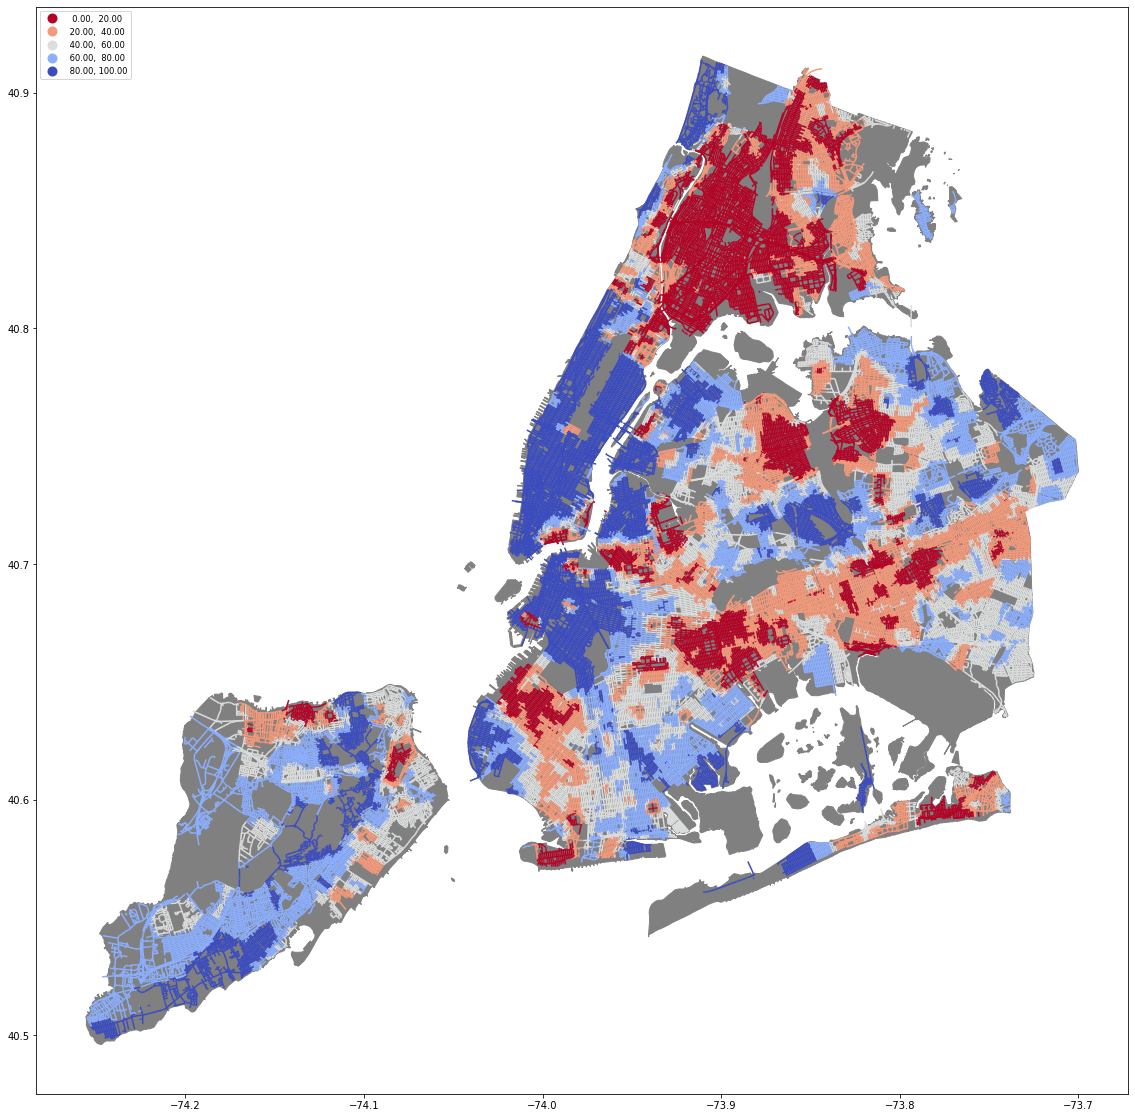

In [ ]:
ax = ct2010.to_crs(4326).plot(figsize=(20,20), facecolor='grey', edgecolor='grey')
HCI_Corridor_Geo.plot(column='HCI', k=5, scheme='Quantiles',cmap='coolwarm_r',
                                             legend=True, legend_kwds={'loc':'upper left','fontsize':'small'}
                                             ,ax=ax)

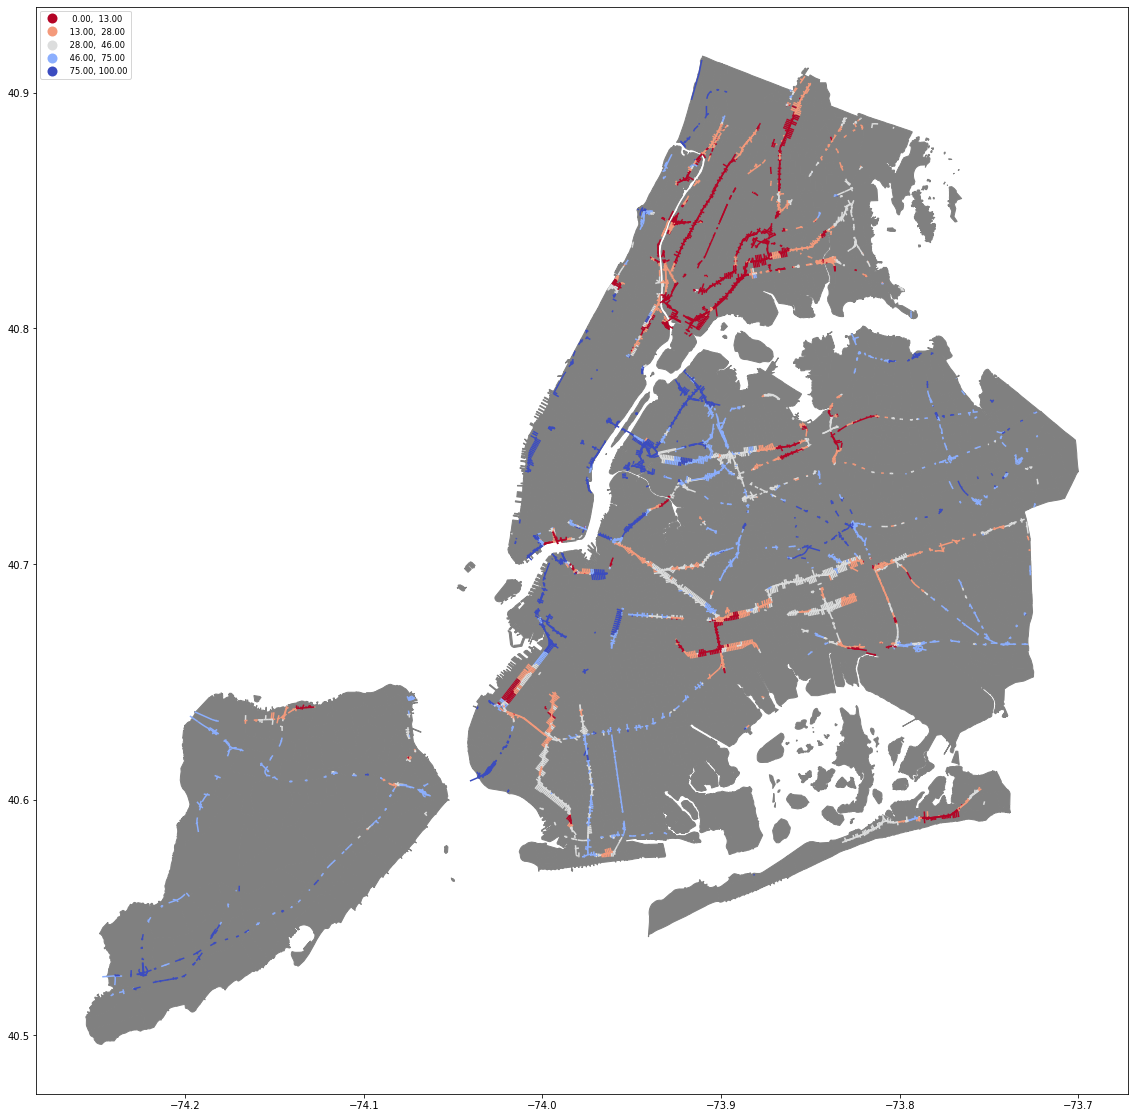

In [ ]:
ax = ct2010.to_crs(4326).plot(figsize=(20,20), facecolor='grey', edgecolor='grey') # #FAFAFA
HCI_Corridor_Geo.loc[HCI_Corridor_Geo.ELSPACE == 1].plot(column='HCI', k=5, scheme='Quantiles',cmap='coolwarm_r',
                                             legend=True, legend_kwds={'loc':'upper left','fontsize':'small'}
                                             , ax=ax)

In [ ]:
HCI_Corridor_Geo.loc[HCI_Corridor_Geo.ELSPACE == 1]

,TotalPopulation,HCI,SE,E,NE,N,T,SE_Unemploy,SE_Insurance,SE_Poverty,SE_English,E_Advance,E_PreS,NE_Tem,NE_Ozone,NE_PM25,N_HFood,N_TreeD,N_LandUseMix,T_WalkVSDrive,T_Transit,T_NodeD,MH,PH,PopRank,SegmentID,Street,StreetCode_left,SHAPE_Leng,geometry,ELSPACE
332,2537.000000,47.887600,60.052935,25.976531,59.517672,55.523293,19.428686,80.817610,51.666667,67.723343,56.753408,25.905895,55.900000,42.483969,99.602684,46.039320,4.440892e-16,9.978376,80.003188,28.314372,6.776942,26.896360,43.452381,44.827586,1,0018459,SURF AVENUE,383630,143.179602,"LINESTRING (-73.98122 40.57557, -73.98173 40.5...",1.0
333,2537.000000,47.887600,60.052935,25.976531,59.517672,55.523293,19.428686,80.817610,51.666667,67.723343,56.753408,25.905895,55.900000,42.483969,99.602684,46.039320,4.440892e-16,9.978376,80.003188,28.314372,6.776942,26.896360,43.452381,44.827586,1,0018476,STILLWELL AVENUE,381830,523.624312,"LINESTRING (-73.98156 40.57698, -73.98122 40.5...",1.0
334,4003.000000,48.436274,69.277605,26.036918,49.829145,37.708474,10.936082,73.270440,85.476190,81.844380,41.883519,32.071390,0.000000,34.678122,97.007079,36.828361,4.440892e-16,20.007796,47.710524,16.648213,4.668042,13.417388,66.666667,63.054187,2,0018738,86 STREET,310880,253.577496,"LINESTRING (-73.99972 40.60548, -73.99900 40.6...",1.0
335,3730.500000,49.064109,67.891434,26.181243,52.541091,44.168902,11.865211,81.918239,70.595238,80.259366,36.555143,28.934559,30.150000,37.485478,97.488217,37.238870,4.440892e-16,23.562644,52.517026,18.311163,5.372072,13.489414,64.285714,57.635468,1,0018740,86 STREET,310880,262.625476,"LINESTRING (-73.99900 40.60506, -73.99825 40.6...",1.0
336,3730.500000,49.064109,67.891434,26.181243,52.541091,44.168902,11.865211,81.918239,70.595238,80.259366,36.555143,28.934559,30.150000,37.485478,97.488217,37.238870,4.440892e-16,23.562644,52.517026,18.311163,5.372072,13.489414,64.285714,57.635468,1,0018742,86 STREET,310880,262.193773,"LINESTRING (-73.99825 40.60461, -73.99751 40.6...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11724,7301.500000,37.544855,54.549611,23.125857,36.428012,37.671228,21.623311,63.050314,81.904762,52.161383,78.872367,25.202812,34.500000,37.202423,73.734602,4.042642,4.440892e-16,31.906714,36.240264,8.805103,6.025632,52.699759,40.178571,34.975369,3,9017052,PARK AVENUE,127790,115.945577,"LINESTRING (-73.94417 40.79803, -73.94397 40.7...",1.0
11729,7301.500000,37.544855,54.549611,23.125857,36.428012,37.671228,21.623311,63.050314,81.904762,52.161383,78.872367,25.202812,34.500000,37.202423,73.734602,4.042642,4.440892e-16,31.906714,36.240264,8.805103,6.025632,52.699759,40.178571,34.975369,3,9017065,PARK AVENUE,127790,56.481234,"LINESTRING (-73.94486 40.79709, -73.94476 40.7...",1.0
11730,7301.500000,37.544855,54.549611,23.125857,36.428012,37.671228,21.623311,63.050314,81.904762,52.161383,78.872367,25.202812,34.500000,37.202423,73.734602,4.042642,4.440892e-16,31.906714,36.240264,8.805103,6.025632,52.699759,40.178571,34.975369,3,9017066,PARK AVENUE,127790,38.454398,"LINESTRING (-73.94476 40.79722, -73.94469 40.7...",1.0
11735,3990.500000,60.429704,77.333406,38.863272,51.897390,24.378060,36.332139,83.333333,94.880952,75.216138,74.659232,34.829638,100.000000,44.976672,94.488895,8.124244,4.440892e-16,35.318179,16.053354,58.074490,10.021889,50.247398,62.500000,43.842365,2,9023987,DELANCEY STREET,116310,18.173495,"LINESTRING (-73.97857 40.71552, -73.97851 40.7...",1.0


In [ ]:
HCI_EL_Corridor_Geo

In [ ]:
h11dddggg

# Vehicle Collision

In [ ]:
VehCrash = pd.read_csv('./Data/Raw_Data/Transportation/Motor_Vehicle_Collisions_Crashes.csv')
VehCrash.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,07/20/2022,1:25,NaN,NaN,40.835808,-73.89083,"(40.835808, -73.89083)",BOSTON ROAD,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Backing Unsafely,Unspecified,NaN,NaN,NaN,4547589,Sedan,Sedan,NaN,NaN,NaN
1,07/21/2022,5:20,NaN,NaN,NaN,NaN,NaN,FDR DRIVE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unsafe Speed,Unspecified,NaN,NaN,NaN,4548075,Sedan,Sedan,NaN,NaN,NaN
2,04/14/2021,5:32,NaN,NaN,NaN,NaN,NaN,BRONX WHITESTONE BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4407480,Sedan,Sedan,NaN,NaN,NaN
3,04/13/2021,21:35,BROOKLYN,11217.0,40.683580,-73.97617,"(40.68358, -73.97617)",NaN,NaN,620 ATLANTIC AVENUE,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4407147,Sedan,NaN,NaN,NaN,NaN
4,04/15/2021,16:15,NaN,NaN,NaN,NaN,NaN,HUTCHINSON RIVER PARKWAY,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Pavement Slippery,NaN,NaN,NaN,NaN,4407665,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [ ]:
VehCrash['CRASH DATE'] = pd.to_datetime(VehCrash['CRASH DATE'])

In [ ]:
VehCrash2022 = VehCrash.loc[(VehCrash['CRASH DATE'] >= '2022-1') & (VehCrash['LATITUDE'] > 0)].dropna(subset=['LOCATION','BOROUGH'])

VehCrash2022['PedCrash'] = VehCrash2022.iloc[:,12:16].sum(axis=1) # only get pedestrians and cyclist
VehCrash2022.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,PedCrash
767,2022-06-27,10:30,BROOKLYN,11236.0,40.651653,-73.91738,"(40.651653, -73.91738)",AVENUE A,EAST 91 STREET,NaN,0.0,0.0,0,0,0,0,0,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,4542682,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,0
768,2022-07-07,20:29,QUEENS,11378.0,40.729633,-73.89563,"(40.729633, -73.89563)",NaN,NaN,53-69 69 STREET,0.0,0.0,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4545349,Pick-up Truck,Sedan,NaN,NaN,NaN,0
769,2022-07-12,13:00,MANHATTAN,10065.0,40.767967,-73.96822,"(40.767967, -73.96822)",MADISON AVENUE,EAST 66 STREET,NaN,1.0,0.0,0,0,0,0,1,0,Unspecified,NaN,NaN,NaN,NaN,4548087,Station Wagon/Sport Utility Vehicle,E-Scooter,NaN,NaN,NaN,0
770,2022-07-20,10:07,STATEN ISLAND,10301.0,40.613650,-74.10211,"(40.61365, -74.10211)",NaN,NaN,27 CAYUGA AVENUE,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4548777,Sedan,NaN,NaN,NaN,NaN,0
771,2022-07-20,13:00,QUEENS,11419.0,40.684020,-73.82308,"(40.68402, -73.82308)",NaN,NaN,107-31 LEFFERTS BOULEVARD,1.0,0.0,0,0,0,0,1,0,Reaction to Uninvolved Vehicle,Unspecified,NaN,NaN,NaN,4547967,Sedan,E scooter,NaN,NaN,NaN,0


In [ ]:
PedCrash2022 = VehCrash2022[VehCrash2022['PedCrash'] > 0] 
PedCrash2022.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,PedCrash
772,2022-07-19,10:15,BRONX,10455.0,40.818880,-73.916504,"(40.81888, -73.916504)",MELROSE AVENUE,EAST 153 STREET,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4549115,E-Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,1
777,2022-07-21,6:39,QUEENS,11105.0,40.776962,-73.902400,"(40.776962, -73.9024)",20 AVENUE,38 STREET,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4548035,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN,1
778,2022-07-22,16:13,BROOKLYN,11238.0,40.686516,-73.967500,"(40.686516, -73.9675)",CLINTON AVENUE,GREENE AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4548535,Sedan,NaN,NaN,NaN,NaN,1
781,2022-07-18,21:54,BROOKLYN,11213.0,40.669890,-73.933810,"(40.66989, -73.93381)",SCHENECTADY AVENUE,LINCOLN PLACE,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4548756,Sedan,NaN,NaN,NaN,NaN,1
792,2022-07-22,19:19,BROOKLYN,11234.0,40.632847,-73.928375,"(40.632847, -73.928375)",UTICA AVENUE,AVENUE H,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4548537,Sedan,Bike,NaN,NaN,NaN,1


In [ ]:
# 
from shapely.geometry import mapping, Polygon, Point
geometry = [Point(i) for i in list((zip(PedCrash2022['LONGITUDE'],PedCrash2022['LATITUDE'])))]
PedCrash2022Geo = gpd.GeoDataFrame(PedCrash2022,geometry=geometry)
PedCrash2022Geo.set_crs(epsg=4326, inplace=True)# wgs 84
PedCrash2022Geo.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,PedCrash,geometry
772,2022-07-19,10:15,BRONX,10455.0,40.818880,-73.916504,"(40.81888, -73.916504)",MELROSE AVENUE,EAST 153 STREET,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4549115,E-Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,1,POINT (-73.91650 40.81888)
777,2022-07-21,6:39,QUEENS,11105.0,40.776962,-73.902400,"(40.776962, -73.9024)",20 AVENUE,38 STREET,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4548035,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN,1,POINT (-73.90240 40.77696)
778,2022-07-22,16:13,BROOKLYN,11238.0,40.686516,-73.967500,"(40.686516, -73.9675)",CLINTON AVENUE,GREENE AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4548535,Sedan,NaN,NaN,NaN,NaN,1,POINT (-73.96750 40.68652)
781,2022-07-18,21:54,BROOKLYN,11213.0,40.669890,-73.933810,"(40.66989, -73.93381)",SCHENECTADY AVENUE,LINCOLN PLACE,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4548756,Sedan,NaN,NaN,NaN,NaN,1,POINT (-73.93381 40.66989)
792,2022-07-22,19:19,BROOKLYN,11234.0,40.632847,-73.928375,"(40.632847, -73.928375)",UTICA AVENUE,AVENUE H,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4548537,Sedan,Bike,NaN,NaN,NaN,1,POINT (-73.92838 40.63285)


In [ ]:
PedCrash2022Geo.BOROUGH.unique()

array(['BRONX', 'QUEENS', 'BROOKLYN', 'MANHATTAN', 'STATEN ISLAND'],
      dtype=object)

In [ ]:
PedCrash2022Geo.describe()

,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID,PedCrash
count,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.0,4.823000e+03,4823.000000
mean,40.726207,-73.929134,1.050176,0.008086,0.664731,0.006842,0.363881,0.001244,0.018246,0.0,4.521517e+06,1.036699
std,0.077851,0.067629,0.297876,0.089569,0.535909,0.082443,0.491822,0.035253,0.175426,0.0,1.698068e+04,0.213843
min,40.505527,-74.238180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.491215e+06,1.000000
25%,40.666263,-73.978250,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.506689e+06,1.000000
50%,40.722620,-73.938995,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.521047e+06,1.000000
75%,40.774300,-73.889720,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,4.536554e+06,1.000000
max,40.907990,-73.715890,5.000000,1.000000,4.000000,1.000000,3.000000,1.000000,4.000000,0.0,4.549715e+06,4.000000


In [ ]:
PedCrash2022Geo.to_file('./Data/Processed_Data/PedCrash2022Geo.geojson', driver='GeoJSON')

In [ ]:
EL_Corridor = gpd.read_file('./Data/Processed_Data/EL_Corridor.geojson')
EL_Corridor.head()

,OBJECTID,Street,StreetCode_left,SegmentID,SHAPE_Leng,ELSPACE,geometry
0,19.0,JEROME AVENUE,242820,0073071,868.014699,1.0,"LINESTRING (1009885.522 250359.413, 1010372.41..."
1,20.0,GRAND CONCOURSE,236420,0072377,336.706440,0.0,"LINESTRING (1009832.957 248173.236, 1010040.24..."
2,52.0,GRAND CONCOURSE,236420,0176245,290.127040,0.0,"LINESTRING (1011245.972 250395.171, 1011399.24..."
3,56.0,EAST TREMONT AVENUE,229620,0175844,55.118715,0.0,"LINESTRING (1010221.240 248813.054, 1010255.72..."
4,115.0,EAST FORDHAM ROAD,229220,0121127,304.862019,0.0,"LINESTRING (1017891.566 251070.048, 1017989.56..."


In [ ]:
EL_Corridor_Buffer = EL_Corridor.copy()
EL_Corridor_Buffer['geometry'] = EL_Corridor.buffer(distance=50, cap_style=2)
EL_Corridor_Buffer.head()

,OBJECTID,Street,StreetCode_left,SegmentID,SHAPE_Leng,ELSPACE,geometry
0,19.0,JEROME AVENUE,242820,0073071,868.014699,1.0,"POLYGON ((1010331.024 251106.057, 1010413.811 ..."
1,20.0,GRAND CONCOURSE,236420,0072377,336.706440,0.0,"POLYGON ((1010000.845 248469.352, 1010079.648 ..."
2,52.0,GRAND CONCOURSE,236420,0176245,290.127040,0.0,"POLYGON ((1011356.793 250667.920, 1011441.699 ..."
3,56.0,EAST TREMONT AVENUE,229620,0175844,55.118715,0.0,"POLYGON ((1010294.730 248801.338, 1010216.719 ..."
4,115.0,EAST FORDHAM ROAD,229220,0121127,304.862019,0.0,"POLYGON ((1018012.329 251054.701, 1018101.098 ..."


In [ ]:
PedCrash2022_Corridor = gpd.sjoin(EL_Corridor_Buffer, PedCrash2022Geo.to_crs(2263), how="left", op='intersects')
PedCrash2022_Corridor = PedCrash2022_Corridor.fillna(0)
PedCrash2022_Corridor.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


,OBJECTID,Street,StreetCode_left,SegmentID,SHAPE_Leng,ELSPACE,geometry,index_right,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,PedCrash
0,19.0,JEROME AVENUE,242820,0073071,868.014699,1.0,"POLYGON ((1010331.024 251106.057, 1010413.811 ...",0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
1,20.0,GRAND CONCOURSE,236420,0072377,336.706440,0.0,"POLYGON ((1010000.845 248469.352, 1010079.648 ...",0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
2,52.0,GRAND CONCOURSE,236420,0176245,290.127040,0.0,"POLYGON ((1011356.793 250667.920, 1011441.699 ...",0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
3,56.0,EAST TREMONT AVENUE,229620,0175844,55.118715,0.0,"POLYGON ((1010294.730 248801.338, 1010216.719 ...",0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
4,115.0,EAST FORDHAM ROAD,229220,0121127,304.862019,0.0,"POLYGON ((1018012.329 251054.701, 1018101.098 ...",0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0.0


In [ ]:
PedCrash2022_Corridor.groupby('SegmentID').agg({'StreetCode_left':'mean','ELSPACE':'mean','PedCrash':'sum'}).describe()

,StreetCode_left,ELSPACE,PedCrash
count,1.226200e+04,12262.000000,12262.000000
mean,3.091088e+36,0.239276,0.151851
std,3.422880e+38,0.426659,0.484761
min,1.101100e+05,0.000000,0.000000
25%,2.292200e+05,0.000000,0.000000
50%,3.468300e+05,0.000000,0.000000
75%,4.510900e+05,0.000000,0.000000
max,3.790290e+40,1.000000,7.000000


In [ ]:
EL_Corridor

,OBJECTID,Street,StreetCode_left,SegmentID,SHAPE_Leng,ELSPACE,geometry
0,19.0,JEROME AVENUE,242820,0073071,868.014699,1.0,"LINESTRING (1009885.522 250359.413, 1010372.41..."
1,20.0,GRAND CONCOURSE,236420,0072377,336.706440,0.0,"LINESTRING (1009832.957 248173.236, 1010040.24..."
2,52.0,GRAND CONCOURSE,236420,0176245,290.127040,0.0,"LINESTRING (1011245.972 250395.171, 1011399.24..."
3,56.0,EAST TREMONT AVENUE,229620,0175844,55.118715,0.0,"LINESTRING (1010221.240 248813.054, 1010255.72..."
4,115.0,EAST FORDHAM ROAD,229220,0121127,304.862019,0.0,"LINESTRING (1017891.566 251070.048, 1017989.56..."
...,...,...,...,...,...,...,...
12257,225251.0,VICTORY BOULEVARD,553000,0293616,245.782474,0.0,"LINESTRING (928206.767 152767.084, 927991.286 ..."
12258,225342.0,NEW DORP LANE,539800,0296827,632.318962,0.0,"LINESTRING (957124.028 144947.663, 957656.162 ..."
12259,225343.0,NEW DORP LANE,539800,0296828,90.777875,0.0,"LINESTRING (957656.162 144606.107, 957732.557 ..."
12260,226063.0,FOREST AVENUE,529150,0321232,316.846841,0.0,"LINESTRING (946446.858 166951.059, 946192.166 ..."
